# Final project

group1

B104020035 陳達豐 （組長）

B104020033 章德宏

B104020041 張世諭

M124020024 賴壹誠

## A.動機和分析目的

因為成員皆對於加密貨幣有些許了解，但沒有從社群媒體分析的角度去探討過加密貨幣，希望藉由這次的報告能夠對加密貨幣有更新的理解

主要想分析及了解的動機有以下三點：

1.   我們假設在虛擬貨幣市場有大事發生時（例如：暴漲或減半等事件），社群聲量及討論文章數皆會大幅增加，所以利用上課所學之知識來驗證這一猜想
2.   分析不同時間上某些固定單字（比特幣）在社群媒體的出現次數多寡
3.   分析社群情緒的頻率和比例等方式來觀察加密貨幣市場
4.   分析社群聲量與虛擬貨幣價格走勢之關係







## B.資料集

資料來源：

+ 工作流程平台蒐集dcard 理財版(money)、股票版(stock)文章
+ 關鍵字：「加密貨幣」、「虛擬貨幣」、「比特幣」、「山寨幣」(2550筆)
+ 時間： 2022-01-01 ~ 2024-06-07
+ 原因：希望抓取較新的資料，因為比較貼近現實，且較容易推測未來之情況


## C.資料的分析過程與視覺化的分析結果與解釋

### 目的：根據時間線來看文章代表字出現次數
文章代表字的定義就是一篇文章裡出現最多次的字就是文章代表字

#### 資料預處理

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab/SMA')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 下載台北思源黑體並命名為 TaipeiSansTCBeta-Regular.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 添加字體
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-06-10 13:32:06--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.15.238, 2607:f8b0:4025:802::200e
Connecting to drive.google.com (drive.google.com)|172.217.15.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-06-10 13:32:06--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.65.97, 2607:f8b0:4025:804::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.65.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  39.0MB/s    in 0.5s    

2024-06-10 13:32:11 (39.0 MB

In [ ]:
#匯入資料
df = pd.read_csv('./data/dcard_crypto.csv', encoding = 'UTF-8')
df.head(3)

system_id dataSource                                    artUrl  \
0          1      Dcard  https://www.dcard.tw/f/money/p/237834785   
1          2      Dcard  https://www.dcard.tw/f/money/p/238995620   
2          3      Dcard  https://www.dcard.tw/f/money/p/238542917   

               artDate                               artTitle  \
0  2022-01-06 04:37:30  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1  2022-05-26 09:36:31                          比特幣&以太坊或許迎來瀑布   
2  2022-04-06 12:09:50                            為什麼房地產不能做空?   

                                          artContent boardID  commentCount  \
0  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   money             0   
1  以太幣大周期線走勢圖，連陰單陽慢慢走高線走勢，雖然說性力不明顯也沒有直接價格破位低點，壓制，...   money             1   
2  這世界上從吃的東西小麥黃豆紅豆玉米\n到金屬都有期貨\n連無形的指數加密貨幣都可以做空\n然...   money             6   

  department gender  school  
0  neferarem      M      飛飛  
1        NaN      M  中州科技大學  
2    光電與通訊學系      M    亞洲大學

In [ ]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = [ 'dataSource', 'department', 'commentCount', 'school', 'gender', 'boardID', 'artUrl']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

#清除日期欄位的時間
clear_df["artDate"] = pd.to_datetime(clear_df["artDate"])
clear_df['artDate'] = clear_df['artDate'].dt.date

clear_df

system_id     artDate                               artTitle  \
0             1  2022-01-06  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1             2  2022-05-26                          比特幣&以太坊或許迎來瀑布   
2             3  2022-04-06                            為什麼房地產不能做空?   
3             4  2022-01-06         用手機line挖礦的方法 未上市的幣類似之前的狗狗幣 柴犬幣   
4             5  2022-04-02                        程式交易｜加密貨幣 4/1紀錄   
...         ...         ...                                    ...   
2545        770  2024-04-19                       程式交易｜加密貨幣 4/18紀錄   
2546        771  2024-04-17                       程式交易｜加密貨幣 4/16紀錄   
2547        772  2024-04-20                       程式交易｜加密貨幣 4/19紀錄   
2548        773  2024-04-20                   比特幣減半啦🔥所以比特幣減半就會暴漲嗎？   
2549        774  2024-04-20                            1-3萬ETF配置詢問   

                                             artContent  \
0     今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   
1     以太幣大周期線走勢圖，連陰單陽慢慢走高線走勢，雖然說性力不明顯也沒有直接價格破位低點，壓制，...   
2     這世界上從吃的東西小麥黃豆紅豆玉米\n到金屬都有期貨\n連無形的指數加密貨幣都可以做空\n然...   
3     分享一下用line挖礦 不用成本\n每天一次 有可能發財 也可能沒有\n但不用成本 上市之後...   
4     2022.04.01\n當日收益：1778.6701\n本金：50w\n\n註記：無\n\n...   
...                                                 ...   
2545  2024.04.18\n當日現貨收益：4034.5187\n本金：現貨 50w\n\n註記：...   
2546  2024.04.16\n當日現貨收益：1865.4147\n本金：現貨 50w\n\n註記：...   
2547  2024.04.19\n當日現貨收益：1404.8381\n本金：現貨 50w\n\n註記：...   
2548  《比特幣減半啦‼️》\n你還在觀望到底要不要開始買加密貨幣嗎？\n\n➡️你知道比特幣減半是...   
2549  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   

                                               sentence  
0     今天要為大家介紹ETFETF英文原文為Exchange Traded Fund，中文稱為「指...  
1     以太幣大周期線走勢圖，連陰單陽慢慢走高線走勢，雖然說性力不明顯也沒有直接價格破位低點，壓制，...  
2     這世界上從吃的東西小麥黃豆紅豆玉米到金屬都有期貨連無形的指數加密貨幣都可以做空然後你他媽跟我...  
3     分享一下用line挖礦 不用成本每天一次 有可能發財 也可能沒有但不用成本 上市之後就可以賣...  
4     2022.04.01當日收益：1778.6701本金：50w。註記：無。程式使用API串聯幣...  
...                                                 ...  
2545  2024.04.18當日現貨收益：4034.5187本金：現貨 50w。註記：合約策略結清，...  
2546  2024.04.16當日現貨收益：1865.4147本金：現貨 50w。註記：合約策略結清，...  
2547  2024.04.19當日現貨收益：1404.8381本金：現貨 50w。註記：合約策略結清，...  
2548  《比特幣減半啦‼️》你還在觀望到底要不要開始買加密貨幣嗎？。➡️你知道比特幣減半是什麼嗎？➡...  
2549  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...  

[2544 rows x 5 columns]

In [ ]:
#斷句
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

system_id     artDate                               artTitle  \
0              1  2022-01-06  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1              1  2022-01-06  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
2              1  2022-01-06  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
3              1  2022-01-06  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
4              1  2022-01-06  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
...          ...         ...                                    ...   
63601        774  2024-04-20                            1-3萬ETF配置詢問   
63602        774  2024-04-20                            1-3萬ETF配置詢問   
63603        774  2024-04-20                            1-3萬ETF配置詢問   
63604        774  2024-04-20                            1-3萬ETF配置詢問   
63605        774  2024-04-20                            1-3萬ETF配置詢問   

                                              artContent  \
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   
1      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   
2      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   
3      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   
4      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   
...                                                  ...   
63601  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   
63602  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   
63603  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   
63604  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   

                                      sentence  
0      今天要為大家介紹ETFETF英文原文為Exchange Traded Fund  
1                                  中文稱為指數股票型基金  
2                                   是一種由投信公司發行  
3                             追蹤模擬或複製標的指數之績效表現  
4                             在證券交易所上市交易的開放式基金  
...                                        ...  
63601                                把月結餘全都投進去  
63602                             除去虛擬貨幣的120美金  
63603                                 這筆錢大概13萬  
63604                         想請問是否繼續無腦投006208  
63605                  還是需要把一定的比例存美股ETF或美債分散風險  

[62276 rows x 5 columns]

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
# 參數形式手動將字詞加入斷詞字典
words = ['ETF','比特幣','投資圈','山寨幣','虛擬貨幣','加密貨幣','股票型','投信公司']
for w in words:
    jieba.add_word(w, freq=None, tag=None)

# 新增stopwords
with open('./dict/stop_words.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]


Building prefix dict from /content/drive/MyDrive/Colab/SMA/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/Colab/SMA/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u5cff42adb5bc3ec765baa10ce6d15f12.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u5cff42adb5bc3ec765baa10ce6d15f12.cache
Loading model cost 2.696 seconds.
DEBUG:jieba:Loading model cost 2.696 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [ ]:
data = sent_df.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

system_id     artDate                               artTitle  \
0          1  2022-01-06  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1          1  2022-01-06  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
2          1  2022-01-06  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   

                                          artContent  \
0  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   
1  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   
2  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   

                                  sentence word  
0  今天要為大家介紹ETFETF英文原文為Exchange Traded Fund   今天  
1                              中文稱為指數股票型基金   介紹  
2                               是一種由投信公司發行  ETF

#### 文章代表字分析

In [ ]:
# 確保日期欄位的正確格式
data['artDate'] = pd.to_datetime(data['artDate'], errors='coerce')

# 移除無效日期
data = data.dropna(subset=['artDate'])


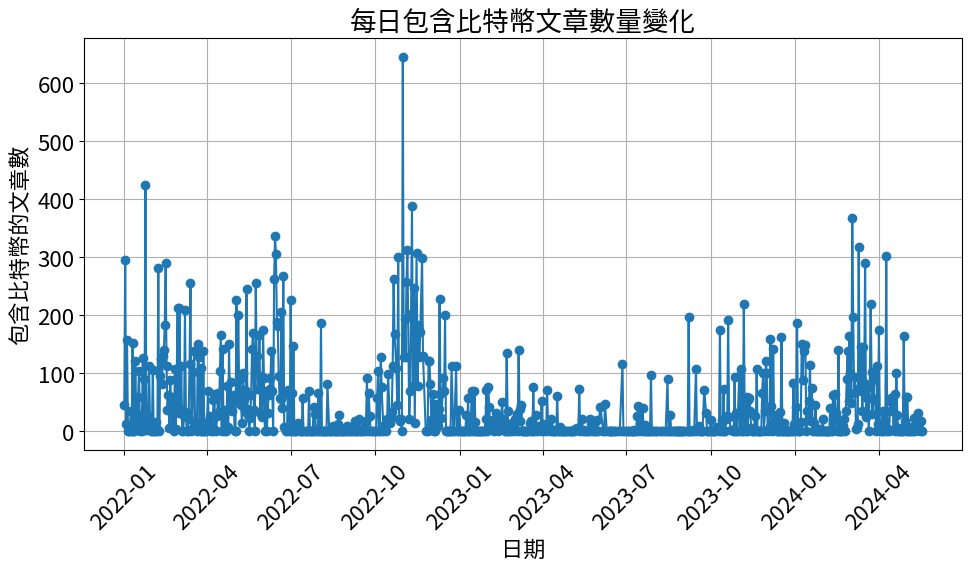

In [ ]:
# 計算比特幣出現次數的函數
def count_keyword_simple(tokens, keyword):
    return ''.join(tokens).count(keyword)

# 新增一個欄位來儲存比特幣的出現次數
data['bitcoin_count'] = data['artContent'].apply(lambda x: count_keyword_simple(getToken(x), '比特幣'))

# 按日期計算每個時間段內出現最多次的文章數量
date_grouped = data.groupby(data['artDate'].dt.date).apply(lambda x: (x['bitcoin_count'] > 0).sum()).reset_index(name='bitcoin_articles')

# 畫圖
plt.figure(figsize=(10, 6))
plt.plot(date_grouped['artDate'], date_grouped['bitcoin_articles'], marker='o')
plt.xlabel('日期')
plt.ylabel('包含比特幣的文章數')
plt.title('每日包含比特幣文章數量變化')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# 顯示圖表
plt.show()

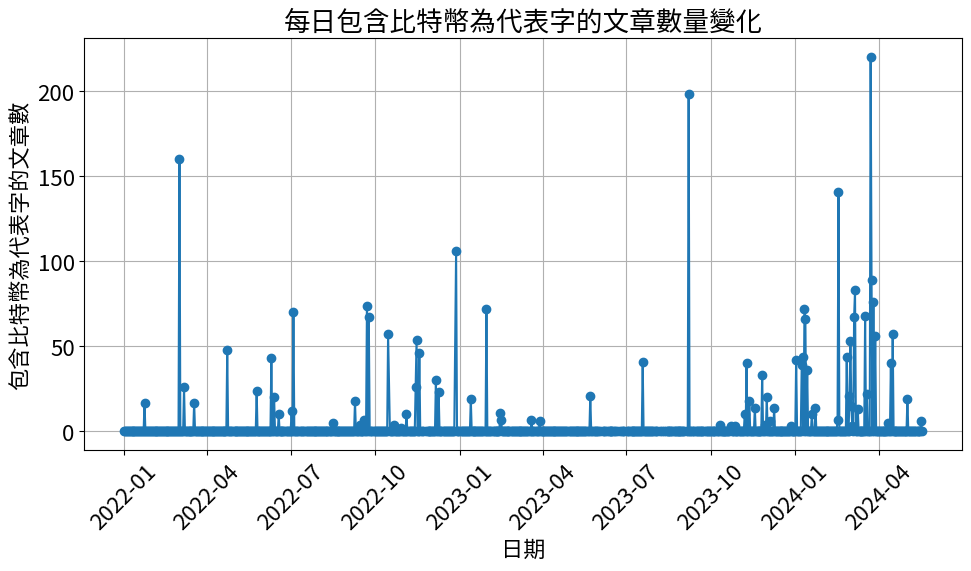

In [ ]:
# 計算每篇文章中出現次數最多的詞
def get_most_common_word(tokens):
    counter = Counter(tokens)
    if counter:
        most_common_word, _ = counter.most_common(1)[0]
        return most_common_word
    return None

# 新增一個欄位來儲存每篇文章中出現次數最多的詞
data['most_common_word'] = data['artContent'].apply(lambda x: get_most_common_word(getToken(x)))

# 計算每天文章中，"比特幣"為該文章中出現次數最多的單詞的文章數量
data['is_bitcoin_most_common'] = data['most_common_word'] == '比特幣'
date_grouped = data.groupby(data['artDate'].dt.date)['is_bitcoin_most_common'].sum().reset_index(name='bitcoin_most_common_articles')

# 畫圖
plt.figure(figsize=(10, 6))
plt.plot(date_grouped['artDate'], date_grouped['bitcoin_most_common_articles'], marker='o')
plt.xlabel('日期')
plt.ylabel('包含比特幣為代表字的文章數')
plt.title('每日包含比特幣為代表字的文章數量變化')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# 顯示圖表
plt.show()

結論：

第一張圖代表的是每日文章中包含比特幣的文章數量為何
可以發現在大約2022年11月時，含有比特幣的文章數突然暴漲，可以推測那時應該發生了跟比特幣有相關的重大事件

而第二張圖則是抓取每日文章中比特幣出現次數最多次的文章數量，透過圖可以發現，在2022/3,2023/9,2024/4皆有高峰值，一樣可以推斷在這三個時間點皆有影響虛擬貨幣的重大事件發生

#### 延伸分析

### 目的：分析社群的情緒來觀察加密貨幣市場


#### 資料預處理

In [ ]:
df = pd.read_csv("dcard_crypto.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date
df.head()

system_id dataSource                                    artUrl     artDate  \
0          1      Dcard  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
1          2      Dcard  https://www.dcard.tw/f/money/p/238995620  2022-05-26   
2          3      Dcard  https://www.dcard.tw/f/money/p/238542917  2022-04-06   
3          4      Dcard  https://www.dcard.tw/f/money/p/237837035  2022-01-06   
4          5      Dcard  https://www.dcard.tw/f/money/p/238509318  2022-04-02   

                                artTitle  \
0  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1                          比特幣&以太坊或許迎來瀑布   
2                            為什麼房地產不能做空?   
3         用手機line挖礦的方法 未上市的幣類似之前的狗狗幣 柴犬幣   
4                        程式交易｜加密貨幣 4/1紀錄   

                                          artContent boardID  commentCount  \
0  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   money             0   
1  以太幣大周期線走勢圖，連陰單陽慢慢走高線走勢，雖然說性力不明顯也沒有直接價格破位低點，壓制，...   money             1   
2  這世界上從吃的東西小麥黃豆紅豆玉米\n到金屬都有期貨\n連無形的指數加密貨幣都可以做空\n然...   money             6   
3  分享一下用line挖礦 不用成本\n每天一次 有可能發財 也可能沒有\n但不用成本 上市之後...   money             0   
4  2022.04.01\n當日收益：1778.6701\n本金：50w\n\n註記：無\n\n...   money             1   

  department gender     school  
0  neferarem      M         飛飛  
1        NaN      M     中州科技大學  
2    光電與通訊學系      M       亞洲大學  
3     topmdd      M      基金好好玩  
4    boooker      M  程式交易｜加密貨幣

資料清理

In [ ]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'dataSource', 'boardID', 'school', 'gender', 'dataSource', 'commentCount', 'department']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

artUrl    artDate  \
0     https://www.dcard.tw/f/money/p/237834785 2022-01-06   
1     https://www.dcard.tw/f/money/p/238995620 2022-05-26   
2     https://www.dcard.tw/f/money/p/238542917 2022-04-06   
3     https://www.dcard.tw/f/money/p/237837035 2022-01-06   
4     https://www.dcard.tw/f/money/p/238509318 2022-04-02   
...                                        ...        ...   
2545  https://www.dcard.tw/f/money/p/255308087 2024-04-19   
2546  https://www.dcard.tw/f/money/p/255289847 2024-04-17   
2547  https://www.dcard.tw/f/money/p/255319495 2024-04-20   
2548  https://www.dcard.tw/f/money/p/255319128 2024-04-20   
2549  https://www.dcard.tw/f/money/p/255325236 2024-04-20   

                                   artTitle  \
0     如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1                             比特幣&以太坊或許迎來瀑布   
2                               為什麼房地產不能做空?   
3            用手機line挖礦的方法 未上市的幣類似之前的狗狗幣 柴犬幣   
4                           程式交易｜加密貨幣 4/1紀錄   
...                                     ...   
2545                       程式交易｜加密貨幣 4/18紀錄   
2546                       程式交易｜加密貨幣 4/16紀錄   
2547                       程式交易｜加密貨幣 4/19紀錄   
2548                   比特幣減半啦🔥所以比特幣減半就會暴漲嗎？   
2549                            1-3萬ETF配置詢問   

                                             artContent YearMonth  \
0     今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01   
1     以太幣大周期線走勢圖，連陰單陽慢慢走高線走勢，雖然說性力不明顯也沒有直接價格破位低點，壓制，...   2022-05   
2     這世界上從吃的東西小麥黃豆紅豆玉米\n到金屬都有期貨\n連無形的指數加密貨幣都可以做空\n然...   2022-04   
3     分享一下用line挖礦 不用成本\n每天一次 有可能發財 也可能沒有\n但不用成本 上市之後...   2022-01   
4     2022.04.01\n當日收益：1778.6701\n本金：50w\n\n註記：無\n\n...   2022-04   
...                                                 ...       ...   
2545  2024.04.18\n當日現貨收益：4034.5187\n本金：現貨 50w\n\n註記：...   2024-04   
2546  2024.04.16\n當日現貨收益：1865.4147\n本金：現貨 50w\n\n註記：...   2024-04   
2547  2024.04.19\n當日現貨收益：1404.8381\n本金：現貨 50w\n\n註記：...   2024-04   
2548  《比特幣減半啦‼️》\n你還在觀望到底要不要開始買加密貨幣嗎？\n\n➡️你知道比特幣減半是...   2024-04   
2549  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04   

                                               sentence  
0     今天要為大家介紹ETFETF英文原文為Exchange Traded Fund，中文稱為「指...  
1     以太幣大周期線走勢圖，連陰單陽慢慢走高線走勢，雖然說性力不明顯也沒有直接價格破位低點，壓制，...  
2     這世界上從吃的東西小麥黃豆紅豆玉米到金屬都有期貨連無形的指數加密貨幣都可以做空然後你他媽跟我...  
3     分享一下用line挖礦 不用成本每天一次 有可能發財 也可能沒有但不用成本 上市之後就可以賣...  
4     2022.04.01當日收益：1778.6701本金：50w。註記：無。程式使用API串聯幣...  
...                                                 ...  
2545  2024.04.18當日現貨收益：4034.5187本金：現貨 50w。註記：合約策略結清，...  
2546  2024.04.16當日現貨收益：1865.4147本金：現貨 50w。註記：合約策略結清，...  
2547  2024.04.19當日現貨收益：1404.8381本金：現貨 50w。註記：合約策略結清，...  
2548  《比特幣減半啦‼️》你還在觀望到底要不要開始買加密貨幣嗎？。➡️你知道比特幣減半是什麼嗎？➡...  
2549  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...  

[2544 rows x 6 columns]

斷句

In [ ]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df

artUrl    artDate  \
0      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
1      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
2      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
3      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
4      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
...                                         ...        ...   
63602  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63603  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63604  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63605  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63606  https://www.dcard.tw/f/money/p/255325236 2024-04-20   

                                    artTitle  \
0      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
2      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
3      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
4      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
...                                      ...   
63602                            1-3萬ETF配置詢問   
63603                            1-3萬ETF配置詢問   
63604                            1-3萬ETF配置詢問   
63605                            1-3萬ETF配置詢問   
63606                            1-3萬ETF配置詢問   

                                              artContent YearMonth  \
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01   
1      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01   
2      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01   
3      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01   
4      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01   
...                                                  ...       ...   
63602  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04   
63603  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04   
63604  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04   
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04   
63606  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04   

                                      sentence  
0      今天要為大家介紹ETFETF英文原文為Exchange Traded Fund  
1                                中文稱為「指數股票型基金」  
2                                   是一種由投信公司發行  
3                            追蹤、模擬或複製標的指數之績效表現  
4                             在證券交易所上市交易的開放式基金  
...                                        ...  
63602                             除去虛擬貨幣的120美金  
63603                                這筆錢大概1-3萬  
63604                         想請問是否繼續無腦投006208  
63605                  還是需要把一定的比例存美股ETF或美債分散風險  
63606                                           

[63607 rows x 6 columns]

In [ ]:
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')
jieba.add_word('公開交易所')
jieba.add_word('加密貨幣')
jieba.add_word('虛擬貨幣')

Building prefix dict from /content/drive/MyDrive/social_media_analysis/final_project/week4/dict/dict.txt ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/social_media_analysis/final_project/week4/dict/dict.txt ...
Dumping model to file cache /tmp/jieba.u19670a0aa44df0b8f6518c41a599a353.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u19670a0aa44df0b8f6518c41a599a353.cache
Loading model cost 1.419 seconds.
DEBUG:jieba:Loading model cost 1.419 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

#把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

artUrl    artDate  \
0      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
1      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
2      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
3      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
4      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
...                                         ...        ...   
63601  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63602  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63603  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63604  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63605  https://www.dcard.tw/f/money/p/255325236 2024-04-20   

                                    artTitle  \
0      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
2      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
3      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
4      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
...                                      ...   
63601                            1-3萬ETF配置詢問   
63602                            1-3萬ETF配置詢問   
63603                            1-3萬ETF配置詢問   
63604                            1-3萬ETF配置詢問   
63605                            1-3萬ETF配置詢問   

                                              artContent YearMonth  \
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01   
1      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01   
2      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01   
3      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01   
4      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01   
...                                                  ...       ...   
63601  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04   
63602  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04   
63603  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04   
63604  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04   
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04   

                                      sentence  
0      今天要為大家介紹ETFETF英文原文為Exchange Traded Fund  
1                                  中文稱為指數股票型基金  
2                                   是一種由投信公司發行  
3                             追蹤模擬或複製標的指數之績效表現  
4                             在證券交易所上市交易的開放式基金  
...                                        ...  
63601                                把月結餘全都投進去  
63602                             除去虛擬貨幣的120美金  
63603                                 這筆錢大概13萬  
63604                         想請問是否繼續無腦投006208  
63605                  還是需要把一定的比例存美股ETF或美債分散風險  

[62276 rows x 6 columns]

斷詞

In [ ]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

artUrl    artDate  \
0      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
0      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
0      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
0      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
0      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
...                                         ...        ...   
63605  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63605  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63605  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63605  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63605  https://www.dcard.tw/f/money/p/255325236 2024-04-20   

                                    artTitle  \
0      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
0      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
0      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
0      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
0      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
...                                      ...   
63605                            1-3萬ETF配置詢問   
63605                            1-3萬ETF配置詢問   
63605                            1-3萬ETF配置詢問   
63605                            1-3萬ETF配置詢問   
63605                            1-3萬ETF配置詢問   

                                              artContent YearMonth    word  
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01      今天  
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01      大家  
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01      介紹  
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01  ETFETF  
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01      英文  
...                                                  ...       ...     ...  
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04      美股  
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04     ETF  
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04      美債  
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04      分散  
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04      風險  

[353752 rows x 6 columns]

移除停用字

In [ ]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()]
stopwords_manual = ["現在", "使用", "可以", "自己", "時間", "知道", "繼續", "需要", "進行", "目前"]
stopwords.extend(stopwords_manual)

In [ ]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

artUrl    artDate  \
0      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
0      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
0      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
0      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
0      https://www.dcard.tw/f/money/p/237834785 2022-01-06   
...                                         ...        ...   
63605  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63605  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63605  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63605  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
63605  https://www.dcard.tw/f/money/p/255325236 2024-04-20   

                                    artTitle  \
0      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
0      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
0      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
0      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
0      如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
...                                      ...   
63605                            1-3萬ETF配置詢問   
63605                            1-3萬ETF配置詢問   
63605                            1-3萬ETF配置詢問   
63605                            1-3萬ETF配置詢問   
63605                            1-3萬ETF配置詢問   

                                              artContent YearMonth    word  
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01      今天  
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01      介紹  
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01  ETFETF  
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01      英文  
0      今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   2022-01      原文  
...                                                  ...       ...     ...  
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04      美股  
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04     ETF  
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04      美債  
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04      分散  
63605  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   2024-04      風險  

[293064 rows x 6 columns]

#### Lexicon-based情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

準備LIWC字典  


In [ ]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

word sentiments
0   ):     affect
1   3q     affect
2   :(     affect
3   :)     affect
4   <3     affect

In [ ]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

In [ ]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

artUrl    artDate  \
0       https://www.dcard.tw/f/money/p/237834785 2022-01-06   
1       https://www.dcard.tw/f/money/p/237834785 2022-01-06   
2       https://www.dcard.tw/f/money/p/237834785 2022-01-06   
3       https://www.dcard.tw/f/money/p/237834785 2022-01-06   
4       https://www.dcard.tw/f/money/p/237834785 2022-01-06   
...                                          ...        ...   
314657  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
314658  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
314659  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
314660  https://www.dcard.tw/f/money/p/255325236 2024-04-20   
314661  https://www.dcard.tw/f/money/p/255325236 2024-04-20   

                                     artTitle  \
0       如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1       如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
2       如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
3       如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
4       如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
...                                       ...   
314657                            1-3萬ETF配置詢問   
314658                            1-3萬ETF配置詢問   
314659                            1-3萬ETF配置詢問   
314660                            1-3萬ETF配置詢問   
314661                            1-3萬ETF配置詢問   

                                               artContent    word sentiments  
0       今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      今天        NaN  
1       今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      介紹        NaN  
2       今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...  ETFETF        NaN  
3       今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      英文        NaN  
4       今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      原文        NaN  
...                                                   ...     ...        ...  
314657  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...      美債        NaN  
314658  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...      分散     affect  
314659  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...      風險     affect  
314660  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...      風險   negative  
314661  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...      風險        anx  

[314662 rows x 6 columns]

正負向情緒詞彙頻率折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖，且正向與負向文章的集合為兩個互斥的集合，我們得以做以下分析

```情緒分析指標```
在情緒分析中，我們從三個不同的指標來看情緒的好壞：
1. **情感詞彙頻率**： 使用情感詞彙列表，其中包含正向和負向情感的詞彙。將文本中的詞與該列表進行匹配，計算正向和負向詞彙的出現次數，從而判斷整體情感傾向。
2. **情感詞彙比例**：不同於單純的計算頻率，比例是某種情緒（例如：正向）佔所有情緒詞中的幾分之幾。這種方法可以避免某一天文章數特別多（詞頻也會隨之變多）而影響情緒的判斷。
2. **情感詞彙分數**： 給每個情感詞彙分配一個權重或分數，然後計算文本中所有情感詞的總分。這種方法允許區分不同情感詞的影響力，進一步細化情感分析的結果。

情感詞彙頻率

In [ ]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative")
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

artDate sentiments  size
1    2022-01-01   negative     3
2    2022-01-01   positive     4
7    2022-01-02   negative    21
8    2022-01-02   positive    64
12   2022-01-03   negative     9
...         ...        ...   ...
3324 2024-05-15   positive    13
3329 2024-05-17   negative     8
3330 2024-05-17   positive     6
3333 2024-05-18   negative    18
3334 2024-05-18   positive     7

[1389 rows x 3 columns]

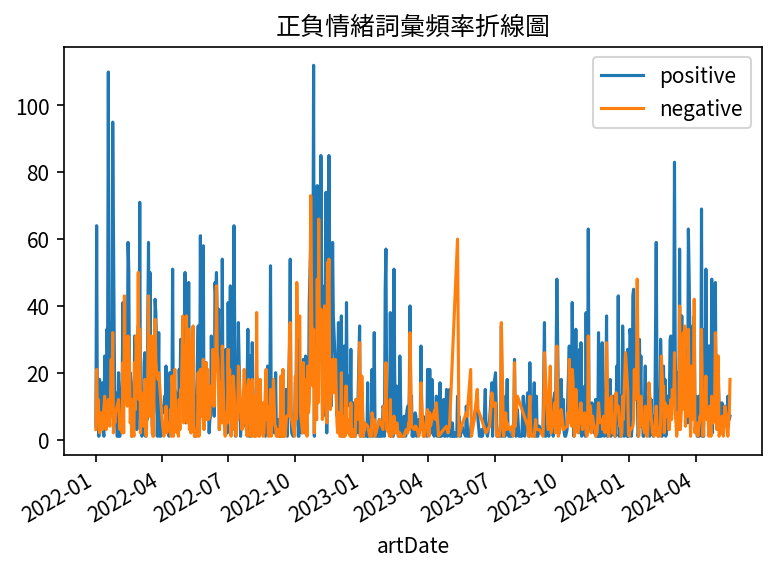

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖")  # 記得加上才能顯示中文(省略)
plt.show()

考慮rolling average


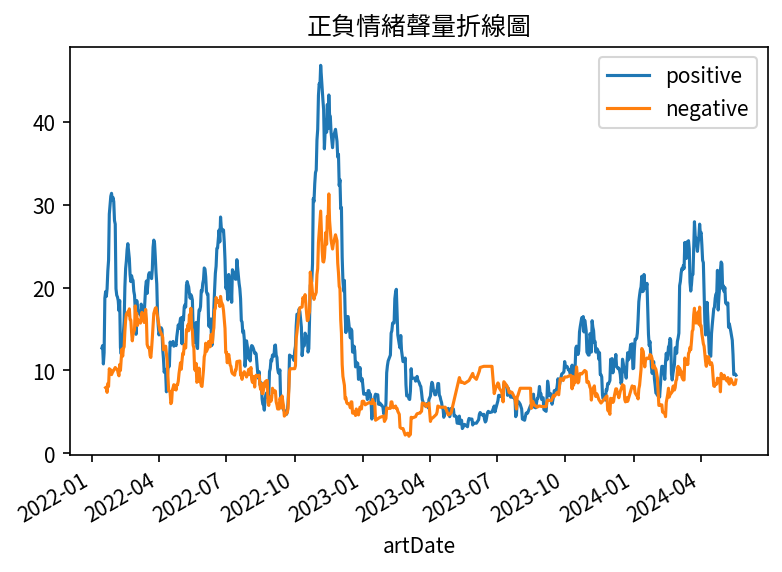

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖")  # 記得加上才能顯示中文
plt.show()

畫出每天的情緒總分數，可以看到正面的詞出現頻率大多都超過負面，還算是氣氛和諧的討論版。

2022-10~2023-01正向與負向情緒都極高


2023-04~2023-07的負面情緒大於正面情緒

```詞頻缺點```

如果某一天有什麼事件發生而導致正負向詞頻數隨之飆高，在趨勢圖看來可能會認為該區間的正負向情緒較為顯著，但也有可能是因為總體情緒詞彙本來就比較多而導致的。

以比例的方式來看，我們可以觀察到某個情緒詞在總體情緒詞彙中所佔的比例，就算某一天文章數相較多，也不會影響到比例的呈現。

情感詞彙比例

In [ ]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

artDate sentiments  size     ratio
1     2022-01-01   negative     3  0.428571
2     2022-01-01   positive     4  0.571429
7     2022-01-02   negative    21  0.247059
8     2022-01-02   positive    64  0.752941
12    2022-01-03   negative     9  0.562500
...          ...        ...   ...       ...
3324  2024-05-15   positive    13  0.928571
3329  2024-05-17   negative     8  0.571429
3330  2024-05-17   positive     6  0.428571
3333  2024-05-18   negative    18  0.720000
3334  2024-05-18   positive     7  0.280000

[1389 rows x 4 columns]

In [ ]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

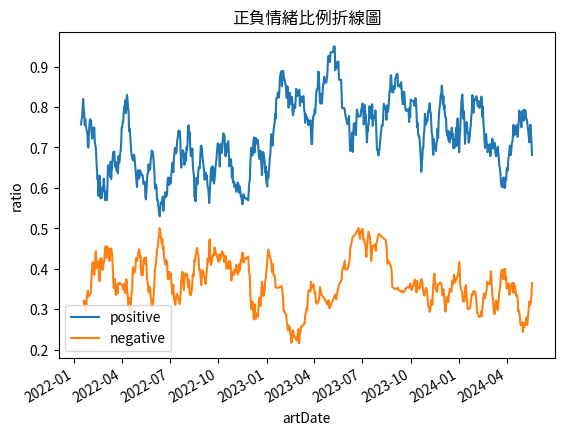

In [ ]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

2023-01~2023-04的負面情緒比例特別小

情感詞彙分數

In [ ]:
sentiment_count

artDate sentiments  size     ratio
1     2022-01-01   negative     3  0.428571
2     2022-01-01   positive     4  0.571429
7     2022-01-02   negative    21  0.247059
8     2022-01-02   positive    64  0.752941
12    2022-01-03   negative     9  0.562500
...          ...        ...   ...       ...
3324  2024-05-15   positive    13  0.928571
3329  2024-05-17   negative     8  0.571429
3330  2024-05-17   positive     6  0.428571
3333  2024-05-18   negative    18  0.720000
3334  2024-05-18   positive     7  0.280000

[1389 rows x 4 columns]

In [ ]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

artDate  negative  positive
0  2022-01-01         3         4
1  2022-01-02        21        64
2  2022-01-03         9         7
3  2022-01-04        12        18
4  2022-01-05         0         1

In [ ]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

artDate  negative  positive  sentiment_value
0  2022-01-01         3         4                1
1  2022-01-02        21        64               43
2  2022-01-03         9         7               -2
3  2022-01-04        12        18                6
4  2022-01-05         0         1                1

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

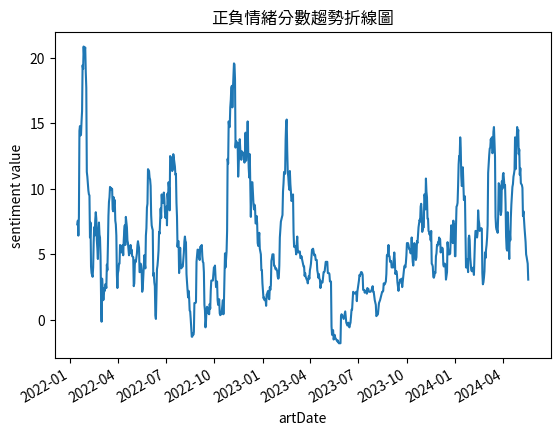

In [ ]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

以文章為單位的情緒分析

In [ ]:
ptt_liwc_df.head()

artUrl     artDate  \
0  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
1  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
2  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
3  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
4  https://www.dcard.tw/f/money/p/237834785  2022-01-06   

                                artTitle  \
0  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
2  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
3  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
4  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   

                                          artContent    word sentiments  
0  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      今天        NaN  
1  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      介紹        NaN  
2  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...  ETFETF        NaN  
3  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      英文        NaN  
4  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      原文        NaN

In [ ]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

artUrl sentiments  size
0     https://www.dcard.tw/f/money/p/237798533     affect     1
1     https://www.dcard.tw/f/money/p/237798533   positive     1
2     https://www.dcard.tw/f/money/p/237802206     affect     6
3     https://www.dcard.tw/f/money/p/237802206   negative     3
4     https://www.dcard.tw/f/money/p/237802206   positive     2
...                                        ...        ...   ...
7460  https://www.dcard.tw/f/stock/p/255425540   negative     3
7461  https://www.dcard.tw/f/stock/p/255425540   positive     3
7462  https://www.dcard.tw/f/stock/p/255425540        sad     1
7463  https://www.dcard.tw/f/stock/p/255537817     affect     2
7464  https://www.dcard.tw/f/stock/p/255537817   negative     1

[7465 rows x 3 columns]

In [ ]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  negative  \
0  https://www.dcard.tw/f/money/p/237798533       1      0    0         0   
1  https://www.dcard.tw/f/money/p/237802206       6      0    0         3   
2  https://www.dcard.tw/f/money/p/237802449       1      0    0         0   
3  https://www.dcard.tw/f/money/p/237805388       9      0    2         2   
4  https://www.dcard.tw/f/money/p/237808314       8      0    1         1   

   positive  sad  
0         1    0  
1         2    2  
2         1    0  
3         6    0  
4         7    0

In [ ]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  negative  \
0  https://www.dcard.tw/f/money/p/237798533       1      0    0         0   
1  https://www.dcard.tw/f/money/p/237802206       6      0    0         3   
2  https://www.dcard.tw/f/money/p/237802449       1      0    0         0   
3  https://www.dcard.tw/f/money/p/237805388       9      0    2         2   
4  https://www.dcard.tw/f/money/p/237808314       8      0    1         1   

   positive  sad  sentiment_value  
0         1    0                1  
1         2    2               -1  
2         1    0                1  
3         6    0                4  
4         7    0                6

In [ ]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

artUrl  affect  anger  anx  negative  \
0     https://www.dcard.tw/f/money/p/237798533       1      0    0         0   
1     https://www.dcard.tw/f/money/p/237802206       6      0    0         3   
2     https://www.dcard.tw/f/money/p/237802449       1      0    0         0   
3     https://www.dcard.tw/f/money/p/237805388       9      0    2         2   
4     https://www.dcard.tw/f/money/p/237808314       8      0    1         1   
...                                        ...     ...    ...  ...       ...   
2235  https://www.dcard.tw/f/stock/p/255341318       1      0    0         0   
2236  https://www.dcard.tw/f/stock/p/255374354      10      0    0         1   
2237  https://www.dcard.tw/f/stock/p/255411250       1      0    0         0   
2238  https://www.dcard.tw/f/stock/p/255425540       7      1    0         3   
2239  https://www.dcard.tw/f/stock/p/255537817       2      0    0         1   

      positive  sad  sentiment_value sentiment_class  
0            1    0                1              正向  
1            2    2               -1              負向  
2            1    0                1              正向  
3            6    0                4              正向  
4            7    0                6              正向  
...        ...  ...              ...             ...  
2235         0    0                0              負向  
2236         9    0                8              正向  
2237         1    0                1              正向  
2238         3    1                0              負向  
2239         0    0               -1              負向  

[2240 rows x 9 columns]

In [ ]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment

system_id dataSource                                    artUrl  \
0             1      Dcard  https://www.dcard.tw/f/money/p/237834785   
1             2      Dcard  https://www.dcard.tw/f/money/p/238995620   
2             3      Dcard  https://www.dcard.tw/f/money/p/238542917   
3             4      Dcard  https://www.dcard.tw/f/money/p/237837035   
4             5      Dcard  https://www.dcard.tw/f/money/p/238509318   
...         ...        ...                                       ...   
2545        770      Dcard  https://www.dcard.tw/f/money/p/255308087   
2546        771      Dcard  https://www.dcard.tw/f/money/p/255289847   
2547        772      Dcard  https://www.dcard.tw/f/money/p/255319495   
2548        773      Dcard  https://www.dcard.tw/f/money/p/255319128   
2549        774      Dcard  https://www.dcard.tw/f/money/p/255325236   

         artDate                               artTitle  \
0     2022-01-06  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1     2022-05-26                          比特幣&以太坊或許迎來瀑布   
2     2022-04-06                            為什麼房地產不能做空?   
3     2022-01-06         用手機line挖礦的方法 未上市的幣類似之前的狗狗幣 柴犬幣   
4     2022-04-02                        程式交易｜加密貨幣 4/1紀錄   
...          ...                                    ...   
2545  2024-04-19                       程式交易｜加密貨幣 4/18紀錄   
2546  2024-04-17                       程式交易｜加密貨幣 4/16紀錄   
2547  2024-04-20                       程式交易｜加密貨幣 4/19紀錄   
2548  2024-04-20                   比特幣減半啦🔥所以比特幣減半就會暴漲嗎？   
2549  2024-04-20                            1-3萬ETF配置詢問   

                                             artContent boardID  commentCount  \
0     今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   money             0   
1     以太幣大周期線走勢圖，連陰單陽慢慢走高線走勢，雖然說性力不明顯也沒有直接價格破位低點，壓制，...   money             1   
2     這世界上從吃的東西小麥黃豆紅豆玉米\n到金屬都有期貨\n連無形的指數加密貨幣都可以做空\n然...   money             6   
3     分享一下用line挖礦 不用成本\n每天一次 有可能發財 也可能沒有\n但不用成本 上市之後...   money             0   
4     2022.04.01\n當日收益：1778.6701\n本金：50w\n\n註記：無\n\n...   money             1   
...                                                 ...     ...           ...   
2545  2024.04.18\n當日現貨收益：4034.5187\n本金：現貨 50w\n\n註記：...   money             0   
2546  2024.04.16\n當日現貨收益：1865.4147\n本金：現貨 50w\n\n註記：...   money             0   
2547  2024.04.19\n當日現貨收益：1404.8381\n本金：現貨 50w\n\n註記：...   money             0   
2548  《比特幣減半啦‼️》\n你還在觀望到底要不要開始買加密貨幣嗎？\n\n➡️你知道比特幣減半是...   money             0   
2549  小弟我目前每月定期定額5000在006208上以及約120美金在虛擬貨幣上(為了分散風險)，...   money             3   

     department gender     school sentiment_class  
0     neferarem      M         飛飛              正向  
1           NaN      M     中州科技大學              負向  
2       光電與通訊學系      M       亞洲大學              正向  
3        topmdd      M      基金好好玩              正向  
4       boooker      M  程式交易｜加密貨幣              正向  
...         ...    ...        ...             ...  
2545    boooker      M  程式交易｜加密貨幣             NaN  
2546    boooker      M  程式交易｜加密貨幣             NaN  
2547    boooker      M  程式交易｜加密貨幣             NaN  
2548  jino_save      M         吉諾              正向  
2549        NaN      M     龍華科技大學              負向  

[2550 rows x 12 columns]

In [ ]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

artDate sentiment_class  size
0     2022-01-01              正向     2
1     2022-01-01              負向     1
2     2022-01-02              正向     6
3     2022-01-03              負向     1
4     2022-01-04              正向     3
...          ...             ...   ...
1131  2024-05-13              負向     2
1132  2024-05-14              正向     2
1133  2024-05-15              正向     2
1134  2024-05-17              負向     4
1135  2024-05-18              負向     1

[1136 rows x 3 columns]

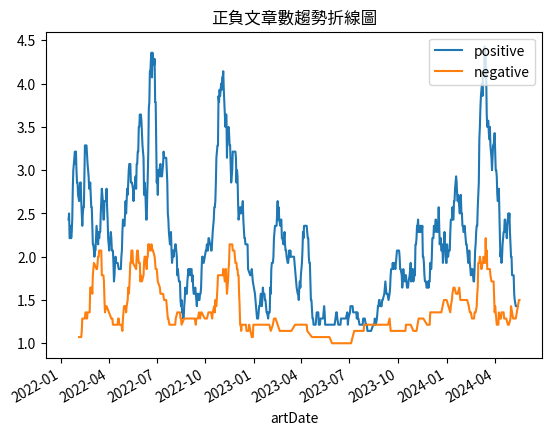

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150)
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])


plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖")
plt.show()

大部分文章都被歸類在正向文章，理財版與股票版討論內容大多偏正面

情緒代表字

In [ ]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

word sentiments  size
1858   風險   negative   698
1857   風險        anx   698
1856   風險     affect   698
0      ok     affect   651
1      ok   positive   651
...   ...        ...   ...
1496   罪名   negative     1
719    悔改   negative     1
718    悔改     affect     1
1500  罪惡感     affect     1
1918   鼻酸        sad     1

[1919 rows x 3 columns]

In [ ]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

word sentiments  size
1      ok   positive   651
222    分享   positive   571
958    支撐   positive   567
1042   朋友   positive   477
1084   歡迎   positive   387
601    希望   positive   313
1786   重要   positive   293
1749   遊戲   positive   291
1564   興趣   positive   285
1442   簡單   positive   266
864    投入   positive   244
1373   相信   positive   205
1762   適合   positive   189
59     不錯   positive   188
815    成功   positive   186

In [ ]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

word sentiments  size
1858   風險   negative   698
1631   詐騙   negative   582
447    壓力   negative   449
374    問題   negative   390
1604   虧損   negative   154
642    強勢   negative   152
1810   降低   negative   135
925    損失   negative   119
734    情緒   negative   115
916    控制   negative   104
829    戰爭   negative    97
1683   貪婪   negative    68
1791   錯誤   negative    67
948    擔心   negative    65
713    恐慌   negative    62

<ipython-input-59-84c14012022f>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
<ipython-input-59-84c14012022f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

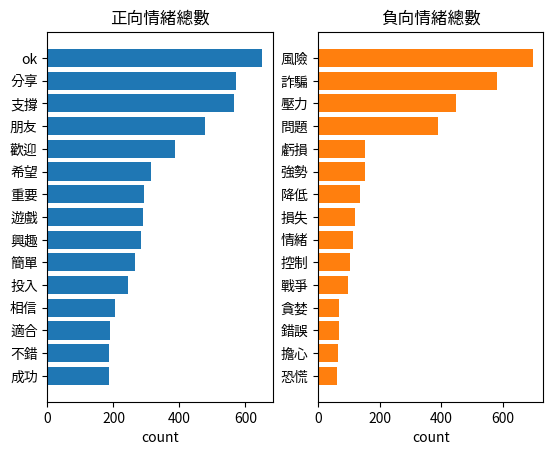

In [ ]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

檢查情緒詞是否符合本文本

In [ ]:
filtered_df = sent_df[sent_df['sentence'].str.contains('虧損', na=False)]
filtered_df.head()

artUrl     artDate           artTitle  \
558  https://www.dcard.tw/f/money/p/240061305  2022-09-22    9000塊炒虛擬貨幣有意義嗎？   
856  https://www.dcard.tw/f/money/p/239725197  2022-08-17  有比活存定存儲蓄險還更好的工具嗎？   
857  https://www.dcard.tw/f/money/p/239725197  2022-08-17  有比活存定存儲蓄險還更好的工具嗎？   
859  https://www.dcard.tw/f/money/p/239725197  2022-08-17  有比活存定存儲蓄險還更好的工具嗎？   
860  https://www.dcard.tw/f/money/p/239725197  2022-08-17  有比活存定存儲蓄險還更好的工具嗎？   

                                            artContent                sentence  
558  圍繞標題我的回答是當然有意義！\n\n9000塊難道不是錢嗎？怎麼說也是一個月的生活費，而且...                   即便虧損了  
856  別人拿加密貨幣當投資，我們拿加密貨幣當理財\n很多人都是因為加密貨幣漲幅更大獲利空間更多才玩...             承擔的虧損風險也就越高  
857  別人拿加密貨幣當投資，我們拿加密貨幣當理財\n很多人都是因為加密貨幣漲幅更大獲利空間更多才玩...  那有沒有一個可以不用承擔虧損風險的加密貨幣呢  
859  別人拿加密貨幣當投資，我們拿加密貨幣當理財\n很多人都是因為加密貨幣漲幅更大獲利空間更多才玩...        年利率820 都不用承擔虧損風險  
860  別人拿加密貨幣當投資，我們拿加密貨幣當理財\n很多人都是因為加密貨幣漲幅更大獲利空間更多才玩...            什麼東西不用承擔虧損風險

In [ ]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

即便虧損了
承擔的虧損風險也就越高
那有沒有一個可以不用承擔虧損風險的加密貨幣呢
年利率820 都不用承擔虧損風險
什麼東西不用承擔虧損風險
000 枚 stETH 隱瞞鉅額虧損
營業虧損擴大 33
EPS 虧損報 018 美元
淨利轉盈為虧虧損 11 億美元
合計 EPS 虧損 498 美元
EPS 虧損 03 美元vs 021
因為自己的失誤導致自己情緒激動或者因為虧損導致自己心情糟糕
不要因為昨天的虧損而影響今天的佈局
一定不要讓盈利變成虧損
薩爾瓦多的總統以國家的資金買入比特幣都已經虧損4000萬美金
你的定存其實每年都在虧損
虧損的不是帳面上的金額
虧損就是虧損另外兩者都是用保證金做買賣的
因此假如你的虧損過大
導致最終虧損 95 本金
是要長期持有 要有配息能力且穩定發放同時擁有殖利率去保護股價 不會過度下跌但我在這邊又加入自己的一個把關標準 股價要處於一個便宜價的狀態利用本益比去分析股價 便宜我才會分批入場 降低投資風險挑選完後 再考慮到成交量的多寡 希望當我要賣出時 不會太難賣最後就剩下 以下些名單 這麼好的事情何樂不為當然我還是有去看財報營收 是否持續成長 股本是否夠大當然還是會有投資錯誤的標的 但可以往後再去做修正至少我買在相對便宜時且分批入場 即便投資錯誤也不會有太多的虧損持續用每個月薪資的部分資金進入市場 雖然不多但我相信複利我曾看過每個月3000也能在65歲時擁有千萬退休金承擔風險 無可指責 但千萬不能孤注一擲如同巴菲特說的擁有一支股票
畢竟帳面虧損
用剩下的錢去虛擬貨幣市場賺回虧損
圖一顯示高風險帶來的高報酬及高虧損
因此面對高風險投資遇到虧損時一定要設定好自己的停損點
造成比較大部分的虧損或是套牢
 持股成本不變持續虧損放空邏輯
從ETH到AVAX等一系列其他代幣也出現了虧損
造成比較大部分的虧損或是套牢
 持股成本不變持續虧損放空邏輯
你除了錯失股市漲幅還可能承受虧損
是要長期持有 要有配息能力且穩定發放同時擁有殖利率去保護股價 不會過度下跌但我在這邊又加入自己的一個把關標準 股價要處於一個便宜價的狀態利用本益比去分析股價 便宜我才會分批入場 降低投資風險挑選完後 再考慮到成交量的多寡 希望當我要賣出時 不會太難賣最後就剩下 以下些名單 這麼好的事情何樂不為當然我還是有去看財報營收 是否持續成長 股本是否夠大當然還是會有投資錯誤的標的

重新計算情緒

In [ ]:
# 設定要移除的字詞列表
words_to_remove = ['ok','情緒']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
1  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
2  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
3  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
4  https://www.dcard.tw/f/money/p/237834785  2022-01-06   

                                artTitle  \
0  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
2  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
3  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
4  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   

                                          artContent    word sentiments  
0  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      今天        NaN  
1  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      介紹        NaN  
2  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...  ETFETF        NaN  
3  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      英文        NaN  
4  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      原文        NaN

<ipython-input-67-31dcf72d5d93>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
<ipython-input-67-31dcf72d5d93>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

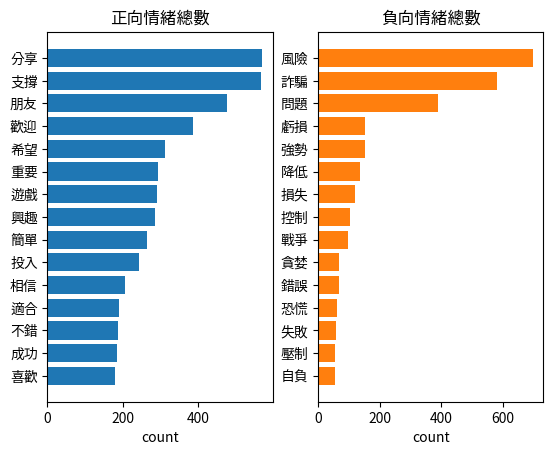

In [ ]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

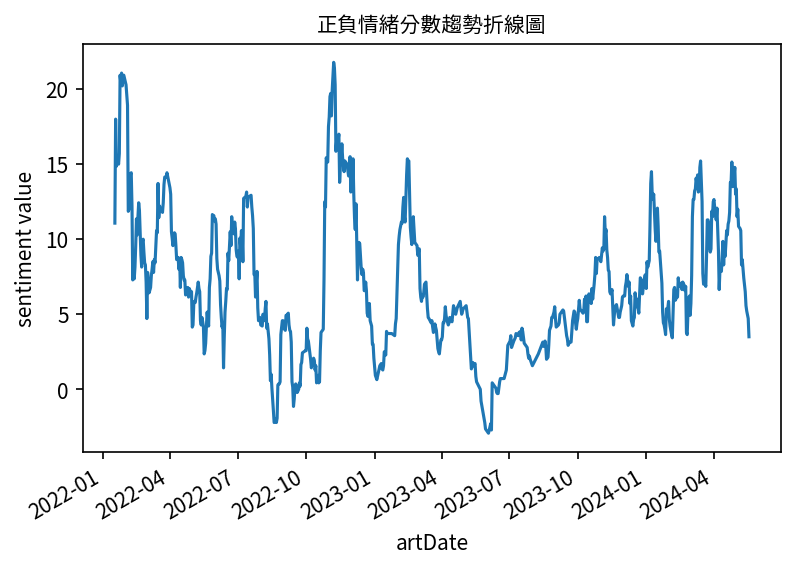

In [ ]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative")
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

文字雲
如果文字雲中的字詞大小越大，代表出現頻率越高

#### 特定時間區段分析

2023-04-01 ~2023-07-31在情緒分數趨勢圖上顯示比較低的分數，我們用文字雲來看一下這段時間出現了什麼關鍵字

將前面計算出的文章情緒類別合併，以利我們過濾出負面文章資料

In [ ]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
1  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
2  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
3  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
4  https://www.dcard.tw/f/money/p/237834785  2022-01-06   

                                artTitle  \
0  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
2  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
3  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
4  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   

                                          artContent    word sentiments  \
0  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      今天        NaN   
1  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      介紹        NaN   
2  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...  ETFETF        NaN   
3  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      英文        NaN   
4  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...      原文        NaN   

  sentiment_class  
0              正向  
1              正向  
2              正向  
3              正向  
4              正向

In [ ]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

artUrl     artDate  \
0  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
1  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
2  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
3  https://www.dcard.tw/f/money/p/237834785  2022-01-06   
4  https://www.dcard.tw/f/money/p/237834785  2022-01-06   

                                artTitle  \
0  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
2  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
3  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
4  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   

                                          artContent  \
0  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   
1  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   
2  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   
3  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   
4  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   

                                  sentence sentiment_class  
0  今天要為大家介紹ETFETF英文原文為Exchange Traded Fund              正向  
1                              中文稱為指數股票型基金              正向  
2                               是一種由投信公司發行              正向  
3                         追蹤模擬或複製標的指數之績效表現              正向  
4                         在證券交易所上市交易的開放式基金              正向

In [ ]:
date = "2023-04-01"
end_date = "2023-07-31"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc

artUrl     artDate  \
199526  https://www.dcard.tw/f/money/p/242389924  2023-05-29   
199527  https://www.dcard.tw/f/money/p/242389924  2023-05-29   
199528  https://www.dcard.tw/f/money/p/242389924  2023-05-29   
199529  https://www.dcard.tw/f/money/p/242389924  2023-05-29   
199530  https://www.dcard.tw/f/money/p/242389924  2023-05-29   
...                                          ...         ...   
232339  https://www.dcard.tw/f/money/p/241822402  2023-04-21   
232340  https://www.dcard.tw/f/money/p/241822402  2023-04-21   
232341  https://www.dcard.tw/f/money/p/241822402  2023-04-21   
232342  https://www.dcard.tw/f/money/p/241822402  2023-04-21   
232343  https://www.dcard.tw/f/money/p/241822402  2023-04-21   

                    artTitle  \
199526  女工程師被詐900萬，五大詐騙手法一次看   
199527  女工程師被詐900萬，五大詐騙手法一次看   
199528  女工程師被詐900萬，五大詐騙手法一次看   
199529  女工程師被詐900萬，五大詐騙手法一次看   
199530  女工程師被詐900萬，五大詐騙手法一次看   
...                      ...   
232339   第一次買股票，複委託付了18%的手續費   
232340   第一次買股票，複委託付了18%的手續費   
232341   第一次買股票，複委託付了18%的手續費   
232342   第一次買股票，複委託付了18%的手續費   
232343   第一次買股票，複委託付了18%的手續費   

                                               artContent word sentiments  \
199526  前陣子才看到一篇聳動的新聞標題\n「跟上主力投資」女工程師遭詐逾900萬\n\n不要以為自己...   陣子        NaN   
199527  前陣子才看到一篇聳動的新聞標題\n「跟上主力投資」女工程師遭詐逾900萬\n\n不要以為自己...   看到        NaN   
199528  前陣子才看到一篇聳動的新聞標題\n「跟上主力投資」女工程師遭詐逾900萬\n\n不要以為自己...   一篇        NaN   
199529  前陣子才看到一篇聳動的新聞標題\n「跟上主力投資」女工程師遭詐逾900萬\n\n不要以為自己...   聳動        NaN   
199530  前陣子才看到一篇聳動的新聞標題\n「跟上主力投資」女工程師遭詐逾900萬\n\n不要以為自己...   新聞        NaN   
...                                                   ...  ...        ...   
232339  剛辦好證券戶，想說先買一股試試看能不能買，結果忘記有最低手續費這件事（有在玩加密貨幣手續費沒...   成交        NaN   
232340  剛辦好證券戶，想說先買一股試試看能不能買，結果忘記有最低手續費這件事（有在玩加密貨幣手續費沒...   沒救        NaN   
232341  剛辦好證券戶，想說先買一股試試看能不能買，結果忘記有最低手續費這件事（有在玩加密貨幣手續費沒...   無法        NaN   
232342  剛辦好證券戶，想說先買一股試試看能不能買，結果忘記有最低手續費這件事（有在玩加密貨幣手續費沒...   退掉        NaN   
232343  剛辦好證券戶，想說先買一股試試看能不能買，結果忘記有最低手續費這件事（有在玩加密貨幣手續費沒...   重來        NaN   

       sentiment_class  
199526              負向  
199527              負向  
199528              負向  
199529              負向  
199530              負向  
...                ...  
232339              負向  
232340              負向  
232341              負向  
232342              負向  
232343              負向  

[4586 rows x 7 columns]

In [ ]:
date = "2023-04-01"
end_date = "2023-07-31"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

word  size
1806    詐騙   195
2148    風險    57
1077    投資    50
681     受害    33
1739  虛擬貨幣    31
...    ...   ...
822    失調症     1
820     太遠     1
818   大魚大肉     1
816    大部分     1
2172    點進     1

[2173 rows x 2 columns]

(-0.5, 399.5, 199.5, -0.5)

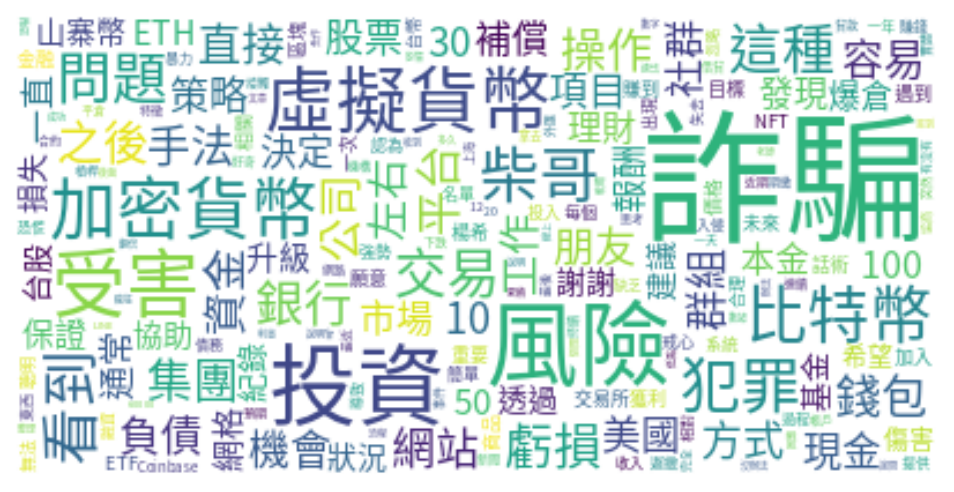

In [ ]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

關鍵字出現了「詐騙」、「風險」的關鍵字，可能是在說明某個事件

(-0.5, 399.5, 199.5, -0.5)

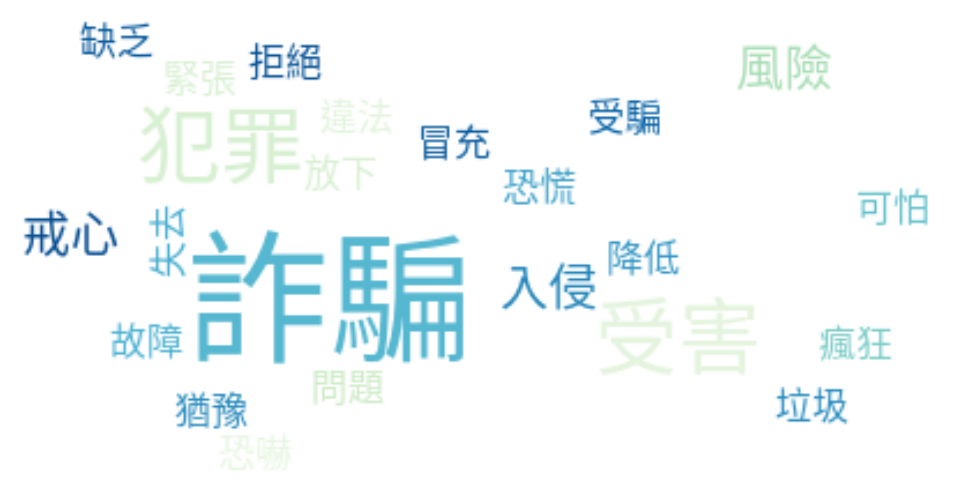

In [ ]:
date = "2023-04-01"
end_date = "2023-07-31"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('詐騙')) & ( # 內文包含詐騙
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud,
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

利用「犯罪」去查看原文內容

In [ ]:
date = "2023-04-01"
end_date = "2023-07-31"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('詐騙')) & (
    sent_df['sentence'].str.contains('犯罪')) # 包含「犯罪」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

artUrl     artDate  \
41161  https://www.dcard.tw/f/money/p/242012593  2023-05-13   
41162  https://www.dcard.tw/f/money/p/242012593  2023-05-13   
41163  https://www.dcard.tw/f/money/p/241996397  2023-05-11   
41164  https://www.dcard.tw/f/money/p/241996397  2023-05-11   
41165  https://www.dcard.tw/f/money/p/241996397  2023-05-11   
...                                         ...         ...   
41221  https://www.dcard.tw/f/money/p/241996397  2023-05-11   
41222  https://www.dcard.tw/f/money/p/241996397  2023-05-11   
41223  https://www.dcard.tw/f/money/p/241996397  2023-05-11   
41224  https://www.dcard.tw/f/money/p/241996397  2023-05-11   
41225  https://www.dcard.tw/f/money/p/241996397  2023-05-11   

                  artTitle                                         artContent  \
41161     程式交易｜加密貨幣 5/12紀錄  2023.05.12\n當日現貨收益：359.1387\n當日合約收益：0\n本金：現貨 5...   
41162     程式交易｜加密貨幣 5/12紀錄  2023.05.12\n當日現貨收益：359.1387\n當日合約收益：0\n本金：現貨 5...   
41163  虛擬貨幣詐騙九大手法！每天都有人上當！  https://megapx-assets.dcard.tw/images/f48ce61e...   
41164  虛擬貨幣詐騙九大手法！每天都有人上當！  https://megapx-assets.dcard.tw/images/f48ce61e...   
41165  虛擬貨幣詐騙九大手法！每天都有人上當！  https://megapx-assets.dcard.tw/images/f48ce61e...   
...                    ...                                                ...   
41221  虛擬貨幣詐騙九大手法！每天都有人上當！  https://megapx-assets.dcard.tw/images/f48ce61e...   
41222  虛擬貨幣詐騙九大手法！每天都有人上當！  https://megapx-assets.dcard.tw/images/f48ce61e...   
41223  虛擬貨幣詐騙九大手法！每天都有人上當！  https://megapx-assets.dcard.tw/images/f48ce61e...   
41224  虛擬貨幣詐騙九大手法！每天都有人上當！  https://megapx-assets.dcard.tw/images/f48ce61e...   
41225  虛擬貨幣詐騙九大手法！每天都有人上當！  https://megapx-assets.dcard.tw/images/f48ce61e...   

                                          sentence sentiment_class  
41161                                 ok等一線交易所進行交易              正向  
41162                            資金皆在自己的交易所帳戶內現貨收益              正向  
41163                                    詐騙手法一戀愛詐騙              負向  
41164                    虛擬貨幣詐騙通常會透過社群平台交友軟體來接觸受害者              負向  
41165  常見軟體有DiscordTelegramFBIGTinder探探SweetRing 等              負向  
...                                            ...             ...  
41221                            或甚至直接入侵真正的官方網站及推特              負向  
41222                              也可能會買 Google 廣告              負向  
41223                                   大量散佈釣魚網站連結              負向  
41224                              讓受騙者不知不覺進入詐騙網站內              負向  
41225                             並主動授權自己的錢包或給予助記詞              負向  

[65 rows x 6 columns]

文章中提到了交易所詐騙的相關事件，像是會透過社群平台交友軟體來接觸受害者

#### 延伸分析：利用SnowNLP進行情緒分析
+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [ ]:
from snownlp import SnowNLP
s = SnowNLP('這部電影很讚')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.786074481210413

In [ ]:
sentence_table = pd.read_csv("raw_data/zh/sentence_table_dcard_crypto.csv") #匯資料

sentiment_date = pd.merge(sentence_table,shu_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head(3)

system_id                                           sentence  \
14          2  以太幣大周期線走勢圖，連陰單陽慢慢走高線走勢，雖然說性力不明顯也沒有直接價格破位低點，壓制，...   
15          2  重點在時段前日白盤承壓下跌，之後開始恢復短線破底圖，美盤在二次承壓下降，位置，該區域也是今天...   
16          2                                                ///   

                artDate dataSource  
14  2023-12-30 01:17:54      Dcard  
15  2023-12-30 01:17:54      Dcard  
16  2023-12-30 01:17:54      Dcard

In [ ]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

system_id                                           sentence  \
14          2  以太幣大周期線走勢圖，連陰單陽慢慢走高線走勢，雖然說性力不明顯也沒有直接價格破位低點，壓制，...   
15          2  重點在時段前日白盤承壓下跌，之後開始恢復短線破底圖，美盤在二次承壓下降，位置，該區域也是今天...   
16          2                                                ///   

                artDate dataSource  sentimentValue  
14  2023-12-30 01:17:54      Dcard        0.936448  
15  2023-12-30 01:17:54      Dcard        0.000146  
16  2023-12-30 01:17:54      Dcard        0.250000

In [ ]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    58564.000000
mean         0.364854
std          0.311693
min          0.000000
25%          0.058626
50%          0.302777
75%          0.535796
max          1.000000
Name: sentimentValue, dtype: float64

<Axes: >

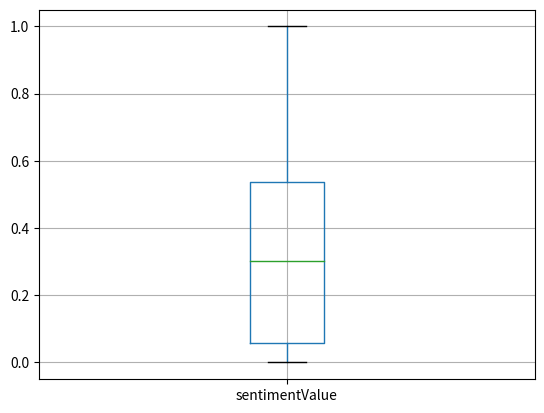

In [ ]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每個月的情緒分數取平均，並轉換時間格式為年月

In [ ]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

artDate  sentimentValue
0   2022-01        0.373293
1   2022-02        0.357700
2   2022-03        0.355218
3   2022-04        0.366731
4   2022-05        0.358843
5   2022-06        0.352294
6   2022-07        0.324203
7   2022-08        0.374676
8   2022-09        0.345527
9   2022-10        0.368075
10  2022-11        0.360829
11  2022-12        0.372406
12  2023-01        0.332635
13  2023-02        0.392810
14  2023-03        0.353244
15  2023-04        0.352119
16  2023-05        0.383342
17  2023-06        0.284451
18  2023-07        0.367023
19  2023-08        0.305690
20  2023-09        0.372042
21  2023-10        0.346575
22  2023-11        0.378366
23  2023-12        0.367920
24  2024-01        0.375378
25  2024-02        0.362363
26  2024-03        0.375462
27  2024-04        0.380892
28  2024-05        0.390855

<ipython-input-58-dcb5938f94ff>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


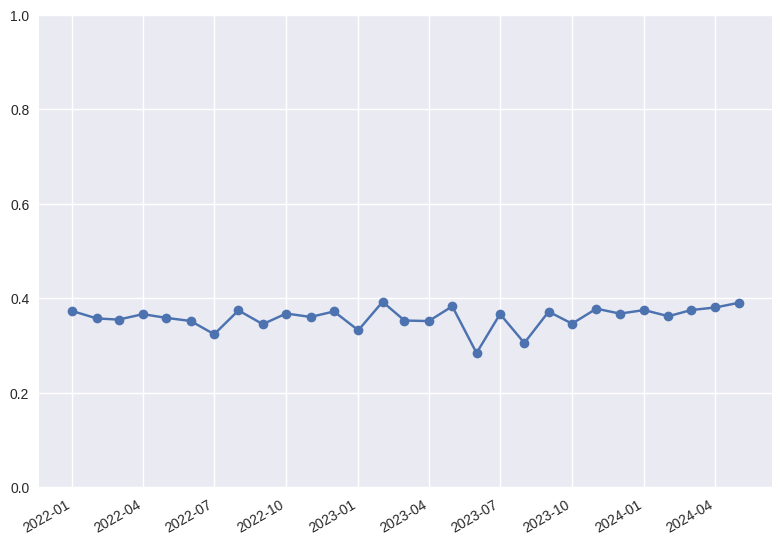

In [ ]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

從上圖中發現大部分天數的情緒值都在0.3~0.4之間，在中性偏低一些，推測是因為dcard理財版與股票版上多數為較負面的文章。我們挑出 2023年07月來分析。

詞彙探索
從上圖中可以發現2023年07月的情緒分數相對低，我們把這個月的負面句子（情緒分數 < 0.5）挑出來看看他們都用甚麼詞。

In [ ]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2023-07']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.5]

filter_sentiment.head()

system_id                                           sentence  artDate  \
18638        538                                          很多人說炒幣盈利難  2023-07   
18640        538         這類人往往把目標訂在個月就翻倍，甚至要翻幾倍，遇上行情好的時候可以，但月月如此不可能  2023-07   
18642        538                               如果你的目標是保證年內穩步增長，其實不難  2023-07   
18644        538  炒幣最重要的不只是技術，心態也很重要，把目標降低，很多技術才有發揮空間，心態才會好，才能保持...  2023-07   
18646        538                                                ///  2023-07   

      dataSource  sentimentValue  
18638      Dcard        0.287990  
18640      Dcard        0.037335  
18642      Dcard        0.106113  
18644      Dcard        0.012649  
18646      Dcard        0.250000

In [ ]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

system_id  sentimentValue word
0        538         0.28799   很多
1        538         0.28799    人
2        538         0.28799    說
3        538         0.28799   炒幣
4        538         0.28799   盈利

In [ ]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

正面詞彙文字雲

In [ ]:
# 自定停用字
with open('dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎', '乎', '乘', '也', '也好', '也罷', '了', '二來', '於', '於是', '於是乎', '云云', '云爾', '些', '亦', '人', '人們', '人家', '什麼', '什麼樣', '今', '介於', '仍', '仍舊', '從', '從此', '從而', '他', '他人', '他們', '以', '以上', '以為', '以便', '以免', '以及', '以故', '以期', '以來', '以至', '以至於', '以致', '們', '任', '任何', '任憑', '似的', '但', '但凡', '但是', '何', '何以', '何況', '何處', '何時', '余外', '作為', '你', '你們', '使', '使得', '例如', '依', '依據', '依照', '便於', '俺', '俺們', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '儻然', '像', '兒', '先不先', '光是', '全體', '全部', '

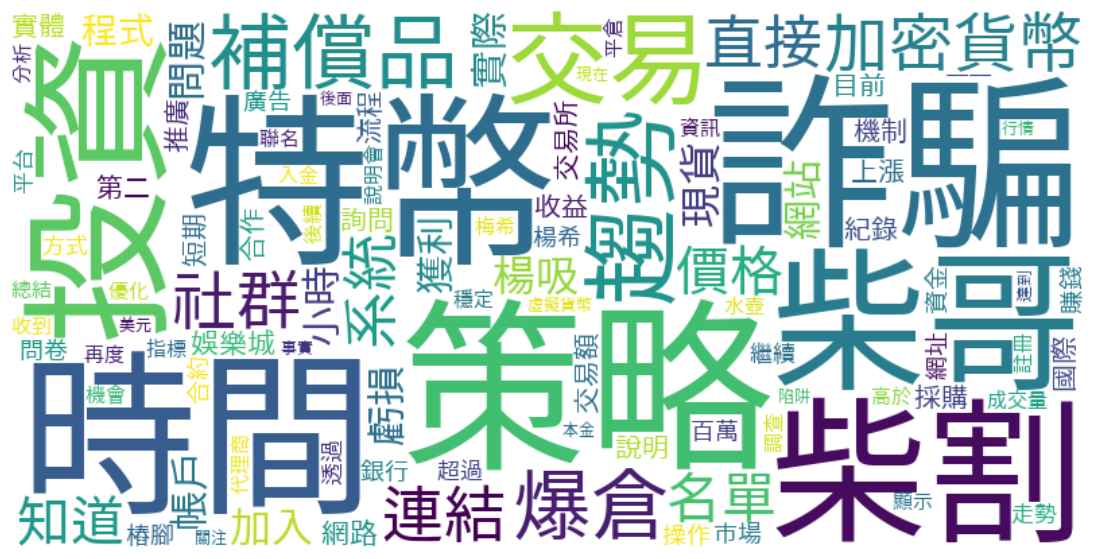

In [ ]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('一些','剛好','可以','覺得','真的','台灣','好像','根本','有點','完全','看到','用','應該','進行','最多','相當','不錯','部分','最多','提供'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800,
                height = 400,
                max_words=100,
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

藉由「詐騙」、「柴哥」、「柴割」等詞彙出現在負向文章中，可以知道或許多數文章對柴哥這個人物有負面的評價，應該是因為他與詐騙事件有關，去dcard搜尋後有找出相關文章

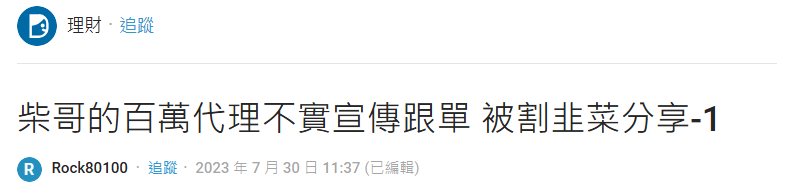

### 目的：分析社群聲量與虛擬貨幣價格走勢之關係

#### 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [ ]:
import time
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# 設定中文字體
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

#### 資料前處理

In [ ]:
dcard = pd.read_csv("../dataset/dcard_crypto.csv")  # 匯資料
dcard.head(3)

system_id dataSource                                    artUrl  \
0          1      Dcard  https://www.dcard.tw/f/money/p/237834785   
1          2      Dcard  https://www.dcard.tw/f/money/p/238995620   
2          3      Dcard  https://www.dcard.tw/f/money/p/238542917   

               artDate                               artTitle  \
0  2022-01-06 04:37:30  如何在最短的時間內賺到人生中的第一桶金 Ep.2 (2022/01/06)   
1  2022-05-26 09:36:31                          比特幣&以太坊或許迎來瀑布   
2  2022-04-06 12:09:50                            為什麼房地產不能做空?   

                                          artContent boardID  commentCount  \
0  今天要為大家介紹ETF\nETF英文原文為Exchange Traded Fund，中文稱為...   money             0   
1  以太幣大周期線走勢圖，連陰單陽慢慢走高線走勢，雖然說性力不明顯也沒有直接價格破位低點，壓制，...   money             1   
2  這世界上從吃的東西小麥黃豆紅豆玉米\n到金屬都有期貨\n連無形的指數加密貨幣都可以做空\n然...   money             6   

  department gender  school  
0  neferarem      M      飛飛  
1        NaN      M  中州科技大學  
2    光電與通訊學系      M    亞洲大學

In [ ]:
# 移除網址格式
dcard["artContent"] = dcard["artContent"].str.replace("(http|https)://.*", "", regex=True)
dcard["artTitle"] = dcard["artTitle"].str.replace("(http|https)://.*", "", regex=True)

# 保留中文和英文字符
dcard["artContent"] = dcard["artContent"].str.replace("[^\u4e00-\u9fa5a-zA-Z]+", "", regex=True)
dcard["artTitle"] = dcard["artTitle"].str.replace("[^\u4e00-\u9fa5a-zA-Z]+", "", regex=True)

dcard['content'] = dcard['artContent']
dcard = dcard.loc[:,["content", "artUrl", "boardID", 'artDate']]  # 文章內容 文章連結
dcard.head(3)

content  \
0  今天要為大家介紹ETFETF英文原文為ExchangeTradedFund中文稱為指數股票型...   
1  以太幣大周期線走勢圖連陰單陽慢慢走高線走勢雖然說性力不明顯也沒有直接價格破位低點壓制所以趨勢...   
2  這世界上從吃的東西小麥黃豆紅豆玉米到金屬都有期貨連無形的指數加密貨幣都可以做空然後你他媽跟我...   

                                     artUrl boardID              artDate  
0  https://www.dcard.tw/f/money/p/237834785   money  2022-01-06 04:37:30  
1  https://www.dcard.tw/f/money/p/238995620   money  2022-05-26 09:36:31  
2  https://www.dcard.tw/f/money/p/238542917   money  2022-04-06 12:09:50

In [ ]:
import jieba

# 設定繁體中文詞庫
jieba.set_dictionary("dict/dict.txt.big")

words = ['ETF', 'BTC', 'ETH', 'btc', 'eth', 'bitcoin', 'blockchain', 'cryptocurrency',
         'cryptocurrencies', 'crypto', 'ethereum', 'litecoin', 'ripple', 'coinbase',
         'binance', 'bitfinex', 'bitstamp', '萊特幣', '瑞波幣','比特幣', '以太幣', '區塊鏈', '加密貨幣', '以太坊', '詐騙', '幣安', '火幣', '現貨', '合約', '量化交易', '量化', '虛擬貨幣', '虛擬幣', '交易所']

for w in words:
    jieba.add_word(w, freq=None, tag=None)




# 新增stopwords
with open("dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    if not isinstance(row, str):
        return []
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙

    # 處理英文
    english_words = [word for word in row.split() if word.isalpha()]
    seg_list.extend(english_words)

    return seg_list

dcard["words"] = dcard["content"].apply(getToken)
dcard.head()

Building prefix dict from /Users/tony/Desktop/MIS581/SMA_2024S/Final project/week10/dict/dict.txt.big ...
2024-06-11 02:25:19,332 : DEBUG : Building prefix dict from /Users/tony/Desktop/MIS581/SMA_2024S/Final project/week10/dict/dict.txt.big ...
Loading model from cache /var/folders/dd/3xjn4tx56812dj8npgdggkh40000gn/T/jieba.ud51abd3de37f521e2c9043c761ed5532.cache
2024-06-11 02:25:19,333 : DEBUG : Loading model from cache /var/folders/dd/3xjn4tx56812dj8npgdggkh40000gn/T/jieba.ud51abd3de37f521e2c9043c761ed5532.cache
Loading model cost 0.470 seconds.
2024-06-11 02:25:19,803 : DEBUG : Loading model cost 0.470 seconds.
Prefix dict has been built successfully.
2024-06-11 02:25:19,804 : DEBUG : Prefix dict has been built successfully.


content  \
0  今天要為大家介紹ETFETF英文原文為ExchangeTradedFund中文稱為指數股票型...   
1  以太幣大周期線走勢圖連陰單陽慢慢走高線走勢雖然說性力不明顯也沒有直接價格破位低點壓制所以趨勢...   
2  這世界上從吃的東西小麥黃豆紅豆玉米到金屬都有期貨連無形的指數加密貨幣都可以做空然後你他媽跟我...   
3  分享一下用line挖礦不用成本每天一次有可能發財也可能沒有但不用成本上市之後就可以賣用手機挖...   
4  當日收益本金w註記無程式使用API串聯幣安火幣krakenok等一線交易所進行交易資金皆在自...   

                                     artUrl boardID              artDate  \
0  https://www.dcard.tw/f/money/p/237834785   money  2022-01-06 04:37:30   
1  https://www.dcard.tw/f/money/p/238995620   money  2022-05-26 09:36:31   
2  https://www.dcard.tw/f/money/p/238542917   money  2022-04-06 12:09:50   
3  https://www.dcard.tw/f/money/p/237837035   money  2022-01-06 10:06:47   
4  https://www.dcard.tw/f/money/p/238509318   money  2022-04-02 01:05:57   

                                               words  
0  [今天, 介紹, ETF, ETF, 英文, 原文, ExchangeTradedFund,...  
1  [以太幣, 周期, 走勢圖, 連陰, 單陽, 慢慢, 走高, 走勢, 性力, 明顯, 直接,...  
2  [世界, 東西, 小麥, 黃豆, 紅豆, 玉米, 金屬, 期貨, 無形, 指數, 加密貨幣,...  
3  [分享, 一下, line, 挖礦, 不用, 成本, 每天, 一次, 發財, 不用, 成本,...  
4  [當日, 收益, 本金, 程式, 使用, API, 串聯, 幣安, 火幣, krakenok...

In [ ]:
dcard = dcard[dcard["words"].str.len() != 0]  # 移除斷詞後為空的文章
dcard = dcard.reset_index(drop=True)

In [ ]:
dcard[dcard["words"].apply(len) == 0]

Empty DataFrame
Columns: [content, artUrl, boardID, artDate, words]
Index: []

In [ ]:
dcard['words'] = dcard['words'].apply(lambda words: [word for word in words if len(word) <= 10])
for i in dcard['words'][0:100]:
    print(i)

['今天', '介紹', 'ETF', 'ETF', '英文', '原文', '中文', '稱為', '指數', '股票', '型基金', '一種', '投信', '公司', '發行', '追蹤', '模擬', '複製', '標的', '指數', '績效', '表現', '證券', '交易所', '上市', '交易', '開放式', '基金', '市場', '許多', 'ETF', '選擇', '指數', '特性', '初期', '階段', '成長', '幅度', '通常', '比較', '時間推移', '成長', '幅度', '隨之', '擴大', '也就是說', '挑選', '國家', '大盤', '指數', 'ETF', '行業', '前景', 'ETF', '指數', '成長', '空間', '遇到', '一時', '下跌', '需要', '擔心', '持續', '持有', '定期', '買入', '時間', '將會', '帶來', '豐厚', '報酬', '那要', '買入', '一檔', 'ETF', '比較', '投資', '覺得', '未來', '存在', '國家', '指數', '未來', '存在', '產業', '指數', 'ETF', '放心', '一直', '資產', '國家', '經濟', '產業', '發展', '得到', '共同', '成長', '初學者', '看到', 'ETF', '裡面', '正二反', '字樣', '選擇', '這檔', 'ETF', '謹記', '最後', '解說', '一下', '差別', '哪裡', '追蹤', '預測', '未來', '一年', '現金', '利率', '最高', '股票', '目標', '取得', '最高', '金額', '股利', '適合', '一定', '資金', '的準', '退休', '族群', '透過', '每年', '發放', '現金', '股利', '當作', '生活', '零用錢', '追蹤', '台灣', '指數', '台灣前', '市值', '上市公司', '目標', '取得', '台股', '市場', '報酬', '適合', '預計', '長期', '持有', '投資', '族群', '取得', '長期', '股市', '報酬', '年輕', '越能', '放長',

簡單的範例說明 `gensim` bag of word 的方式

In [ ]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
corpus = [dictionary.doc2bow(doc) for doc in docs]
corpus

2024-06-11 00:29:43,027 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-06-11 00:29:43,173 : INFO : built Dictionary<31979 unique tokens: ['ETF', '一下', '一定', '一年', '一時']...> from 2514 documents (total 329332 corpus positions)
2024-06-11 00:29:43,173 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<31979 unique tokens: ['ETF', '一下', '一定', '一年', '一時']...> from 2514 documents (total 329332 corpus positions)", 'datetime': '2024-06-11T00:29:43.173964', 'gensim': '4.3.2', 'python': '3.10.6 (v3.10.6:9c7b4bd164, Aug  1 2022, 17:13:48) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.5-arm64-arm-64bit', 'event': 'created'}
2024-06-11 00:29:43,185 : INFO : discarding 25926 tokens: [('台灣前', 1), ('放長', 1), ('敬請期待', 4), ('時間推移', 2), ('正二反', 1), ('的準', 1), ('謹記', 3), ('越能', 1), ('開放式', 1), ('個頭', 1)]...
2024-06-11 00:29:43,185 : INFO : keeping 6053 tokens which were in no less than 5 and no more than 2488 (=99.0%) documents
2024-06-11 00:29:43,190 : INFO :

[[(0, 9),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 2),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 3),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 3),
  (31, 1),
  (32, 1),
  (33, 3),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 2),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 2),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 1),
  (47, 4),
  (48, 1),
  (49, 4),
  (50, 2),
  (51, 1),
  (52, 8),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 2),
  (59, 1),
  (60, 1),
  (61, 2),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 3),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 1),
  (74, 2),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 2),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 2),
  (87, 1),
  (88, 3),
  (89, 1),
  (90, 1),
  (91, 1)

In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

ETF: 0
一下: 1
一定: 2
一年: 3
一時: 4
一檔: 5
一直: 6
一種: 7
上市: 8
上市公司: 9
下跌: 10
中文: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [ ]:
pprint(" ".join(dcard['words'].iloc[10]))


'我想問 是給 家人 女友 不懂事 裝懂 認識 之前 很大 問題 比特幣 被騙 媽媽 覺得 外面 媽媽 合理 嗎裡 包含 手機費 生活 飲食 還債 貸款'


In [ ]:
dictionary.doc2bow(dcard['words'].iloc[600])[:]

[(42, 1),
 (52, 1),
 (237, 1),
 (554, 1),
 (696, 1),
 (831, 1),
 (1459, 1),
 (1902, 1),
 (2094, 1),
 (2519, 1)]

In [ ]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
corpus

[[(0, 9),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 2),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 3),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 3),
  (31, 1),
  (32, 1),
  (33, 3),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 2),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 2),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 1),
  (47, 4),
  (48, 1),
  (49, 4),
  (50, 2),
  (51, 1),
  (52, 8),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 2),
  (59, 1),
  (60, 1),
  (61, 2),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 3),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 1),
  (74, 2),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 2),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 2),
  (87, 1),
  (88, 3),
  (89, 1),
  (90, 1),
  (91, 1)

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [ ]:
ldamodel = LdaModel(
    corpus=corpus,
    id2word=dictionary, # 字典
    num_topics=3, # 生成幾個主題數
    random_state=2024, # 亂數
)

2024-06-11 00:29:54,129 : INFO : using symmetric alpha at 0.3333333333333333
2024-06-11 00:29:54,130 : INFO : using symmetric eta at 0.3333333333333333
2024-06-11 00:29:54,132 : INFO : using serial LDA version on this node
2024-06-11 00:29:54,135 : INFO : running online (single-pass) LDA training, 3 topics, 1 passes over the supplied corpus of 2514 documents, updating model once every 2000 documents, evaluating perplexity every 2514 documents, iterating 50x with a convergence threshold of 0.001000
2024-06-11 00:29:54,136 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-06-11 00:29:54,136 : INFO : PROGRESS: pass 0, at document #2000/2514
2024-06-11 00:29:54,612 : INFO : merging changes from 2000 documents into a model of 2514 documents
2024-06-11 00:29:54,614 : INFO : topic #0 (0.333): 0.018*"交易" + 0.014*"收益" + 0.012*"程式" + 0.011*"加密貨幣" + 0.010*"投資" + 0.010*"合約" + 0.010*"交易所" + 0.009*"現貨" + 0.007*"比

** 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  

In [ ]:
ldamodel.print_topics()

2024-06-11 00:29:57,501 : INFO : topic #0 (0.333): 0.023*"交易" + 0.023*"現貨" + 0.019*"加密貨幣" + 0.018*"交易所" + 0.018*"程式" + 0.018*"收益" + 0.012*"合約" + 0.010*"社群" + 0.009*"投資" + 0.009*"策略"
2024-06-11 00:29:57,502 : INFO : topic #1 (0.333): 0.023*"比特幣" + 0.010*"投資" + 0.007*"市場" + 0.006*"價格" + 0.006*"ETF" + 0.005*"加密貨幣" + 0.005*"現在" + 0.005*"資產" + 0.004*"目前" + 0.004*"趨勢"
2024-06-11 00:29:57,503 : INFO : topic #2 (0.333): 0.009*"交易" + 0.009*"加密貨幣" + 0.008*"合約" + 0.008*"交易所" + 0.008*"市場" + 0.007*"比特幣" + 0.007*"投資" + 0.006*"資金" + 0.006*"現貨" + 0.006*"收益"


[(0,
  '0.023*"交易" + 0.023*"現貨" + 0.019*"加密貨幣" + 0.018*"交易所" + 0.018*"程式" + 0.018*"收益" + 0.012*"合約" + 0.010*"社群" + 0.009*"投資" + 0.009*"策略"'),
 (1,
  '0.023*"比特幣" + 0.010*"投資" + 0.007*"市場" + 0.006*"價格" + 0.006*"ETF" + 0.005*"加密貨幣" + 0.005*"現在" + 0.005*"資產" + 0.004*"目前" + 0.004*"趨勢"'),
 (2,
  '0.009*"交易" + 0.009*"加密貨幣" + 0.008*"合約" + 0.008*"交易所" + 0.008*"市場" + 0.007*"比特幣" + 0.007*"投資" + 0.006*"資金" + 0.006*"現貨" + 0.006*"收益"')]

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：春節旅遊
+ 主題二：中國科技產業
+ 主題三：股市新聞
+ 主題四：中國股市
+ ...
+ 主題十：中美貿易

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [ ]:
ldamodel.get_document_topics(corpus[600])

[(0, 0.03396003), (1, 0.92986864), (2, 0.036171366)]

** 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
np.exp2(-perplexity)

2024-06-11 00:30:03,536 : INFO : -7.589 per-word bound, 192.6 perplexity estimate based on a held-out corpus of 2514 documents with 284010 words


192.59025639971225

In [ ]:
# npmi normalized PMI
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2024-06-10 21:14:43,849 : INFO : using ParallelWordOccurrenceAccumulator<processes=7, batch_size=64> to estimate probabilities from sliding windows
2024-06-10 21:14:44,406 : INFO : 1 batches submitted to accumulate stats from 64 documents (10346 virtual)
2024-06-10 21:14:44,417 : INFO : 2 batches submitted to accumulate stats from 128 documents (21171 virtual)
2024-06-10 21:14:44,419 : INFO : 3 batches submitted to accumulate stats from 192 documents (30564 virtual)
2024-06-10 21:14:44,420 : INFO : 4 batches submitted to accumulate stats from 256 documents (38156 virtual)
2024-06-10 21:14:44,421 : INFO : 5 batches submitted to accumulate stats from 320 documents (45573 virtual)
2024-06-10 21:14:44,422 : INFO : 6 batches submitted to accumulate stats from 384 documents (52705 virtual)
2024-06-10 21:14:44,423 : INFO : 7 batches submitted to accumulate stats from 448 documents (62740 virtual)
2024-06-10 21:14:45,110 : INFO : 8 batches submitted to accumulate stats from 512 documents (7110

這個主題的 PMI score:  0.047677804922488666


In [ ]:
NPMI_model_lda.get_coherence_per_topic()

[-0.020232903618233235, -0.009718389170549527, 0.17298470755624876]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

** 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [ ]:
from gensim.models.ldamulticore import LdaMulticore
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()

for topic_num in topic_num_list:
    # perplexity
    model = LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5, # 訓練次數
        #workers=4  # 核心數量
        )

    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")

2024-06-10 21:14:47,505 : INFO : using symmetric alpha at 0.5
2024-06-10 21:14:47,506 : INFO : using symmetric eta at 0.5
2024-06-10 21:14:47,508 : INFO : using serial LDA version on this node
2024-06-10 21:14:47,510 : INFO : running online LDA training, 2 topics, 5 passes over the supplied corpus of 2514 documents, updating every 14000 documents, evaluating every ~2514 documents, iterating 50x with a convergence threshold of 0.001000
2024-06-10 21:14:47,510 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-06-10 21:14:47,511 : INFO : training LDA model using 7 processes
2024-06-10 21:14:51,285 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/2514, outstanding queue size 1
2024-06-10 21:14:51,299 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #2514/2514, outstanding queue size 2
2024-06-10 21:14:51,783 : INFO : topic #0 (0.500): 0.010*"交易" + 0.009*"比特幣" + 0.00

花費時間: 69.43235874176025 sec


In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )

    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    # model_set[f'k_{topic_num}'] = model

    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 44.16448998451233 sec

2024-06-10 21:16:01,496 : INFO : using symmetric alpha at 0.5
2024-06-10 21:16:01,497 : INFO : using symmetric eta at 0.5
2024-06-10 21:16:01,498 : INFO : using serial LDA version on this node
2024-06-10 21:16:01,499 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 2514 documents, updating model once every 2000 documents, evaluating perplexity every 2514 documents, iterating 50x with a convergence threshold of 0.001000
2024-06-10 21:16:01,499 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-06-10 21:16:01,500 : INFO : PROGRESS: pass 0, at document #2000/2514
2024-06-10 21:16:01,961 : INFO : merging changes from 2000 documents into a model of 2514 documents
2024-06-10 21:16:01,962 : INFO : topic #0 (0.500): 0.008*"交易" + 0.008*"投資" + 0.008*"比特幣" + 0.007*"市場" + 0.006*"目前" + 0.006*"反彈" + 0.005*"現在" + 0.005*"趨勢" + 0.005*"加密貨幣" + 0.004*"繼續"
2024-06-10 21:1

花費時間: 44.16448998451233 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [ ]:
result = pd.DataFrame(result)
result

topic_num   perplexity       pmi
0          2  1757.799661  0.086190
1          3  1657.019915  0.070795
2          4  1513.272716  0.053365
3          5  1346.874692  0.066817
4          6  1336.915277  0.063404
5          7  1299.788440  0.045772
6          8  1313.891107  0.048802
7          9  1280.933577  0.029188

<Axes: xlabel='topic_num'>

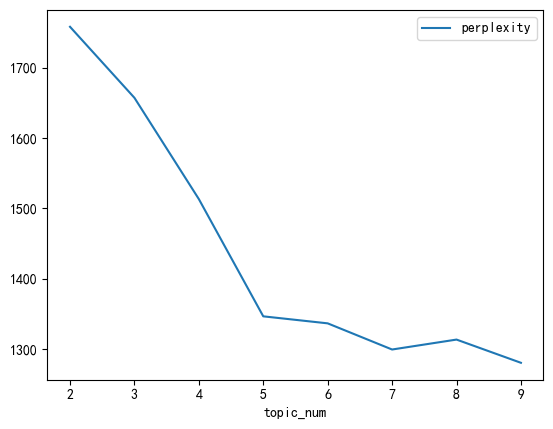

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

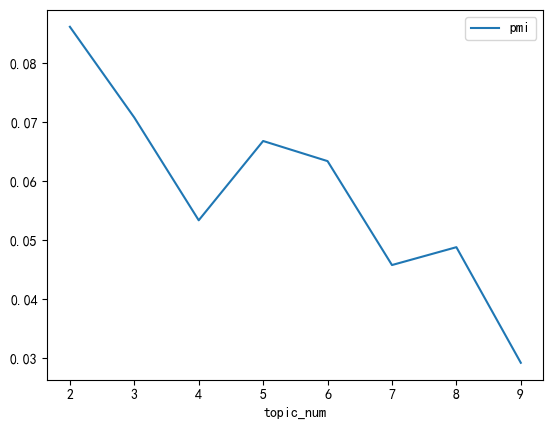

In [ ]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 在 5 之後都不錯，coherence 最高則是 8

#### GuidedLDA

In [ ]:
!pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA

  Cloning https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to /private/var/folders/dd/3xjn4tx56812dj8npgdggkh40000gn/T/pip-install-q9bny9l3/guidedlda_fd0b88f631284323921762f3626754d6
  Running command git clone --filter=blob:none --quiet https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git /private/var/folders/dd/3xjn4tx56812dj8npgdggkh40000gn/T/pip-install-q9bny9l3/guidedlda_fd0b88f631284323921762f3626754d6
  Resolved https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to commit 05c3bf2c18f9d126cc5170256f33e6c1fbc90052
  Preparing metadata (setup.py) ... done


In [ ]:
import guidedlda

In [ ]:
word2id = dictionary.token2id

In [ ]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
seed_topic_list = [
    ["ETF","現貨","etf","區塊鏈", "區塊", "blockchain","NFT","挖礦", "礦工","交易", "交易所","投資", "投資人", "交易平台","錢包", ],
    ["趨勢","上漲","下跌","漲幅","跌幅","漲停","跌停","震盪","型態","區間","反彈","壓力","跌破","進場","出場","多單","空單","多頭","空頭",],
    ["詐騙", "詐欺", "騙局","風險", ],
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
model = guidedlda.GuidedLDA(n_topics=3, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-06-11 02:25:32,038 : INFO : n_documents: 2514
2024-06-11 02:25:32,038 : INFO : vocab_size: 6053
2024-06-11 02:25:32,039 : INFO : n_words: 284010
2024-06-11 02:25:32,040 : INFO : n_topics: 3
2024-06-11 02:25:32,040 : INFO : n_iter: 100
2024-06-11 02:25:32,047 : WARNING : all zero row in document-term matrix found
2024-06-11 02:25:33,050 : INFO : <0> log likelihood: -2529429
2024-06-11 02:25:33,291 : INFO : <20> log likelihood: -2108251
2024-06-11 02:25:33,469 : INFO : <40> log likelihood: -2094153
2024-06-11 02:25:33,645 : INFO : <60> log likelihood: -2089345
2024-06-11 02:25:33,821 : INFO : <80> log likelihood: -2085432
2024-06-11 02:25:33,991 : INFO : <99> log likelihood: -2083537


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))


doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 交易 收益 程式 現貨 合約 交易所 當日 幣安 Instagram 加密貨幣
Topic 1: 反彈 趨勢 比特幣 行情 跌破 現在 附近 繼續 下跌 建議
Topic 2: 投資 比特幣 加密貨幣 市場 交易 資產 目前 交易所 虛擬貨幣 風險


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.149601  0.229336       1        1  65.635074
1     -0.241953 -0.195904       2        1  25.248448
0      0.391554 -0.033432       3        1   9.116478, topic_info=      Term         Freq        Total Category  logprob  loglift
13      交易  3589.000000  3589.000000  Default  30.0000  30.0000
230     收益  2358.000000  2358.000000  Default  29.0000  29.0000
235     程式  2159.000000  2159.000000  Default  28.0000  28.0000
14     交易所  2329.000000  2329.000000  Default  27.0000  27.0000
397     現貨  2049.000000  2049.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
227    區塊鏈   729.409243  1279.203285   Topic3  -3.5694   1.8333
101     資金   728.411433  1434.146136   Topic3  -3.5708   1.7176
24    加密貨幣   765.330411  2592.601200   Topic3  -3.5214   1.1750
1189    策略   264.429684   823.172577   Topic3  -4.5841   1.2595
309     更新    68.858883   226.810189   Topic3  -5.9296   1.2030

[191 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
221       1  0.005776        API
221       3  0.993477        API
0         1  0.984311        ETF
0         2  0.016038        ETF
222       1  0.008982  Instagram
...     ...       ...        ...
615       2  0.916408         預期
617       1  0.896864         風險
617       2  0.103532         風險
621       1  0.069293         點位
621       2  0.931294         點位

[239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

####  主題分佈的應用，搭配其他文章資訊

In [ ]:
# 利用guided LDA模型轉回 theta
doc_topic_dist = model.transform(X)

2024-06-11 02:25:38,179 : WARNING : all zero row in document-term matrix found


In [ ]:
doc_topic_dist

array([[1.84943609e-05, 4.09427304e-02, 9.59038775e-01],
       [4.49333362e-07, 9.03777978e-01, 9.62215722e-02],
       [1.70782726e-04, 1.27965766e-01, 8.71863451e-01],
       ...,
       [9.99975503e-01, 7.80403630e-06, 1.66930986e-05],
       [7.26965888e-06, 8.69561411e-02, 9.13036589e-01],
       [4.69665660e-07, 3.53971693e-04, 9.99645559e-01]])

In [ ]:
topic_category = {0: "加密貨幣風險", 1: "加密貨幣趨勢", 2: "加密貨幣社群"}

In [ ]:
threshold = 0.3
doc_topics = []

for doc in doc_topic_dist:
    topics = [i for i, prob in enumerate(doc) if prob > threshold]
    doc_topics.append(topics)

In [ ]:

# 將數字主題轉換為你定義的主題類別
doc_topic_categories = [[topic_category[topic] for topic in topics] for topics in doc_topics]
doc_topic_categories[:10]

[['加密貨幣社群'],
 ['加密貨幣趨勢'],
 ['加密貨幣社群'],
 ['加密貨幣社群'],
 ['加密貨幣風險'],
 ['加密貨幣社群'],
 ['加密貨幣風險'],
 ['加密貨幣社群'],
 ['加密貨幣趨勢', '加密貨幣社群'],
 ['加密貨幣風險']]

In [ ]:
# 新增主題標籤
dcard['topic'] = doc_topic_categories

In [ ]:
dcard['topic'].value_counts()

topic
[加密貨幣社群]            1247
[加密貨幣風險]             702
[加密貨幣趨勢]             343
[加密貨幣趨勢, 加密貨幣社群]     212
[加密貨幣風險, 加密貨幣社群]       8
[]                     2
Name: count, dtype: int64

In [ ]:
dcard.head()

content  \
0  今天要為大家介紹ETFETF英文原文為ExchangeTradedFund中文稱為指數股票型...   
1  以太幣大周期線走勢圖連陰單陽慢慢走高線走勢雖然說性力不明顯也沒有直接價格破位低點壓制所以趨勢...   
2  這世界上從吃的東西小麥黃豆紅豆玉米到金屬都有期貨連無形的指數加密貨幣都可以做空然後你他媽跟我...   
3  分享一下用line挖礦不用成本每天一次有可能發財也可能沒有但不用成本上市之後就可以賣用手機挖...   
4  當日收益本金w註記無程式使用API串聯幣安火幣krakenok等一線交易所進行交易資金皆在自...   

                                     artUrl boardID              artDate  \
0  https://www.dcard.tw/f/money/p/237834785   money  2022-01-06 04:37:30   
1  https://www.dcard.tw/f/money/p/238995620   money  2022-05-26 09:36:31   
2  https://www.dcard.tw/f/money/p/238542917   money  2022-04-06 12:09:50   
3  https://www.dcard.tw/f/money/p/237837035   money  2022-01-06 10:06:47   
4  https://www.dcard.tw/f/money/p/238509318   money  2022-04-02 01:05:57   

                                               words     topic  
0  [今天, 介紹, ETF, ETF, 英文, 原文, 中文, 稱為, 指數, 股票, 型基金...  [加密貨幣社群]  
1  [以太幣, 周期, 走勢圖, 連陰, 單陽, 慢慢, 走高, 走勢, 性力, 明顯, 直接,...  [加密貨幣趨勢]  
2  [世界, 東西, 小麥, 黃豆, 紅豆, 玉米, 金屬, 期貨, 無形, 指數, 加密貨幣,...  [加密貨幣社群]  
3  [分享, 一下, line, 挖礦, 不用, 成本, 每天, 一次, 發財, 不用, 成本,...  [加密貨幣社群]  
4  [當日, 收益, 本金, 程式, 使用, API, 串聯, 幣安, 火幣, krakenok...  [加密貨幣風險]

In [ ]:
dcard['artDate'] = pd.to_datetime(dcard['artDate'])

In [ ]:
dcard['artDate'] = dcard['artDate'].dt.to_period('M')

In [ ]:
dcard['artDate'] = dcard['artDate'].dt.to_timestamp()


In [ ]:
dcard

content  \
0     今天要為大家介紹ETFETF英文原文為ExchangeTradedFund中文稱為指數股票型...   
1     以太幣大周期線走勢圖連陰單陽慢慢走高線走勢雖然說性力不明顯也沒有直接價格破位低點壓制所以趨勢...   
2     這世界上從吃的東西小麥黃豆紅豆玉米到金屬都有期貨連無形的指數加密貨幣都可以做空然後你他媽跟我...   
3     分享一下用line挖礦不用成本每天一次有可能發財也可能沒有但不用成本上市之後就可以賣用手機挖...   
4     當日收益本金w註記無程式使用API串聯幣安火幣krakenok等一線交易所進行交易資金皆在自...   
...                                                 ...   
2509  當日現貨收益本金現貨w註記合約策略結清僅保留現貨策略程式使用API串聯幣安OKX等一線交易所...   
2510  當日現貨收益本金現貨w註記合約策略結清僅保留現貨策略程式使用API串聯幣安OKX等一線交易所...   
2511  當日現貨收益本金現貨w註記合約策略結清僅保留現貨策略程式使用API串聯幣安OKX等一線交易所...   
2512  比特幣減半啦你還在觀望到底要不要開始買加密貨幣嗎你知道比特幣減半是什麼嗎你知道減半對比特幣有...   
2513  小弟我目前每月定期定額在上以及約美金在虛擬貨幣上為了分散風險近期活存也存到了萬想著可以增加金...   

                                        artUrl boardID    artDate  \
0     https://www.dcard.tw/f/money/p/237834785   money 2022-01-01   
1     https://www.dcard.tw/f/money/p/238995620   money 2022-05-01   
2     https://www.dcard.tw/f/money/p/238542917   money 2022-04-01   
3     https://www.dcard.tw/f/money/p/237837035   money 2022-01-01   
4     https://www.dcard.tw/f/money/p/238509318   money 2022-04-01   
...                                        ...     ...        ...   
2509  https://www.dcard.tw/f/money/p/255308087   money 2024-04-01   
2510  https://www.dcard.tw/f/money/p/255289847   money 2024-04-01   
2511  https://www.dcard.tw/f/money/p/255319495   money 2024-04-01   
2512  https://www.dcard.tw/f/money/p/255319128   money 2024-04-01   
2513  https://www.dcard.tw/f/money/p/255325236   money 2024-04-01   

                                                  words     topic  
0     [今天, 介紹, ETF, ETF, 英文, 原文, 中文, 稱為, 指數, 股票, 型基金...  [加密貨幣社群]  
1     [以太幣, 周期, 走勢圖, 連陰, 單陽, 慢慢, 走高, 走勢, 性力, 明顯, 直接,...  [加密貨幣趨勢]  
2     [世界, 東西, 小麥, 黃豆, 紅豆, 玉米, 金屬, 期貨, 無形, 指數, 加密貨幣,...  [加密貨幣社群]  
3     [分享, 一下, line, 挖礦, 不用, 成本, 每天, 一次, 發財, 不用, 成本,...  [加密貨幣社群]  
4     [當日, 收益, 本金, 程式, 使用, API, 串聯, 幣安, 火幣, krakenok...  [加密貨幣風險]  
...                                                 ...       ...  
2509  [當日, 現貨, 收益, 本金, 現貨, 合約, 策略, 結清, 保留, 現貨, 策略, 程...  [加密貨幣風險]  
2510  [當日, 現貨, 收益, 本金, 現貨, 合約, 策略, 結清, 保留, 現貨, 策略, 程...  [加密貨幣風險]  
2511  [當日, 現貨, 收益, 本金, 現貨, 合約, 策略, 結清, 保留, 現貨, 策略, 程...  [加密貨幣風險]  
2512  [比特幣, 減半, 還在, 觀望, 加密貨幣, 知道, 比特幣, 減半, 知道, 減半, 比...  [加密貨幣社群]  
2513  [小弟, 目前, 每月, 定期, 定額, 美金, 虛擬貨幣, 分散, 風險, 近期, 活存,...  [加密貨幣社群]  

[2514 rows x 6 columns]

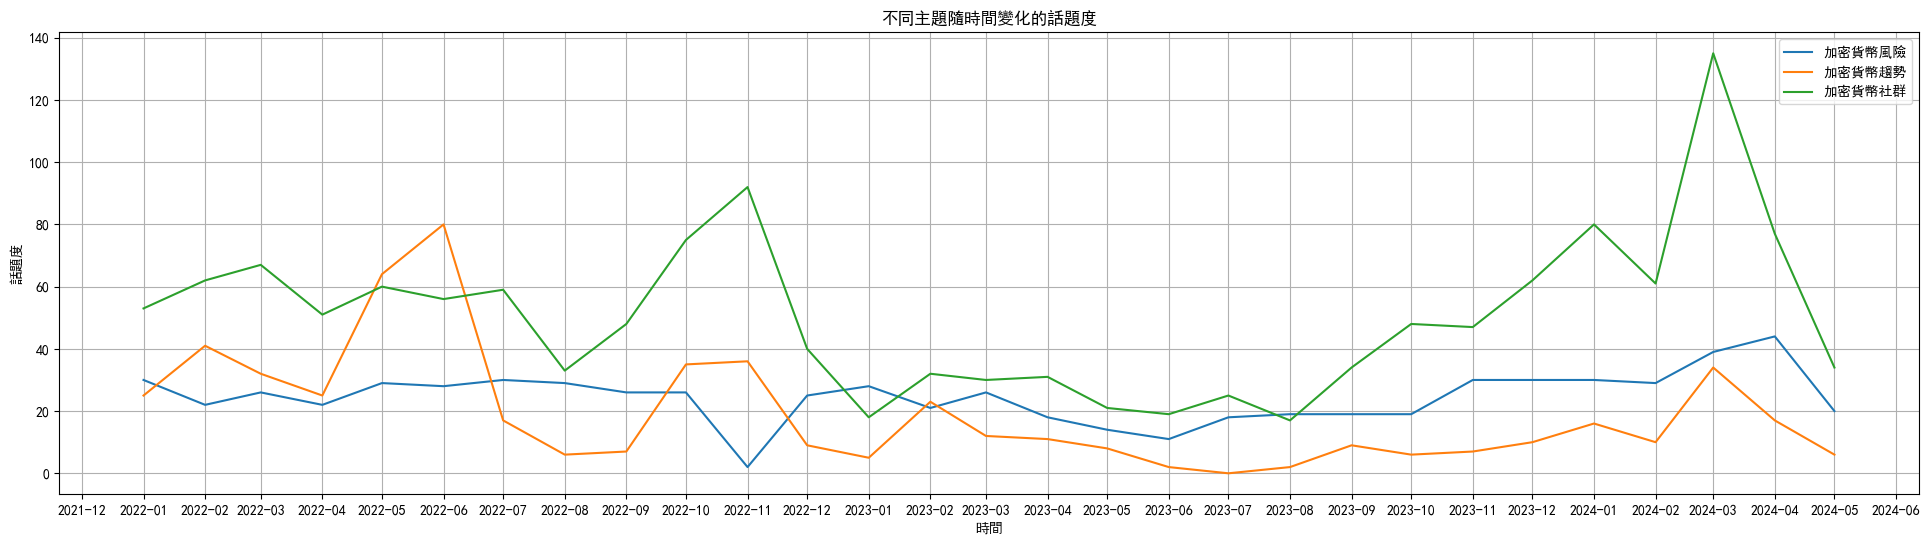

In [ ]:
import matplotlib.dates as mdates
dcard = dcard.explode('topic')
topic_count = dcard.groupby(['artDate', 'topic']).size().unstack(fill_value=0)
topic_category = {"加密貨幣風險": "加密貨幣風險", "加密貨幣趨勢": "加密貨幣趨勢", "加密貨幣社群": "加密貨幣社群"}

# 繪圖
fig, ax = plt.subplots(figsize=(24, 6))

for topic, label in topic_category.items():
    ax.plot(topic_count.index, topic_count[topic], label=label)

ax.xaxis.set_major_locator(mdates.MonthLocator())  # 設置主要刻度為每個月
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 設置日期格式


plt.xlabel('時間')
plt.ylabel('話題度')
plt.title('不同主題隨時間變化的話題度')
plt.legend()
plt.grid(True)
plt.show()

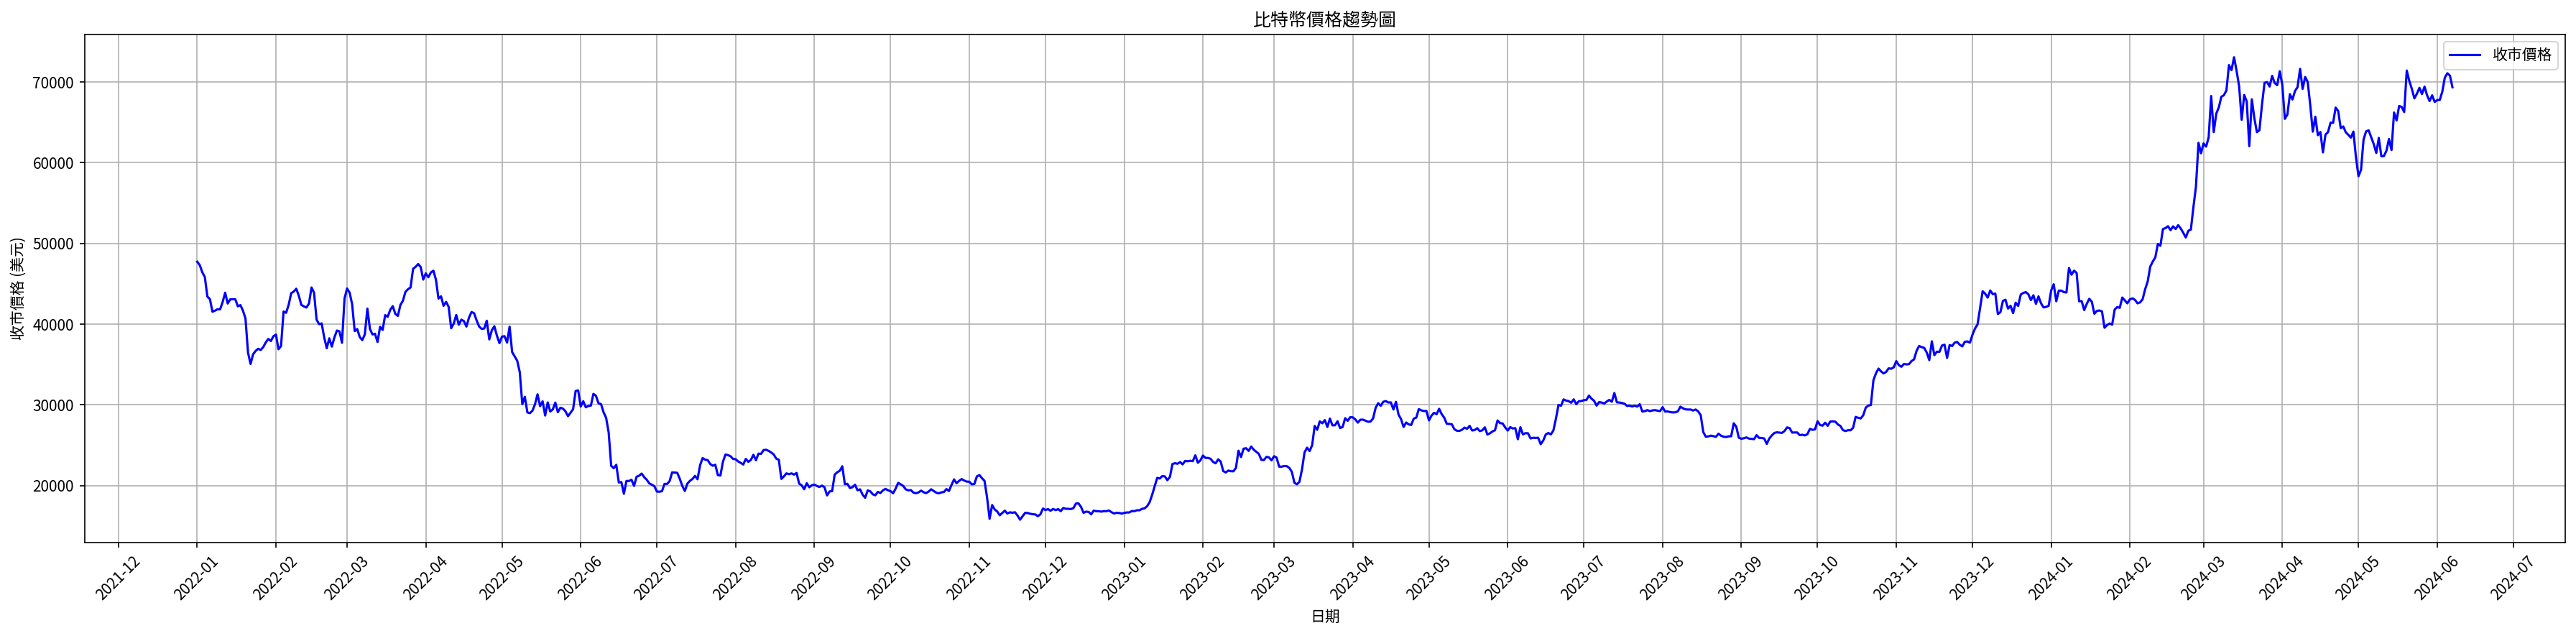

In [ ]:
# @title 對比圖
import matplotlib.dates as mdates
# Replot the closing price trend with corrected data
plt.figure(figsize=(24, 6))
plt.plot(df['日期'], df['收市'], label='收市價格', color='blue')
plt.xlabel('日期')
plt.ylabel('收市價格 (美元)')
plt.title('比特幣價格趨勢圖')
plt.legend()
plt.grid(True)

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 影片連結：https://youtu.be/3cWURHdPgTg